In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc

In [3]:
import pyro
import muvi

In [4]:
%matplotlib
%matplotlib inline

from matplotlib import pyplot as plt
import seaborn as sns

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [5]:
# plotting settings
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("notebook")

Run a quick check if GPU(s) are available and select the least utilized GPU to perform the optimization.

In [6]:
device = "cpu"
try:
    device = f"cuda:{muvi.get_free_gpu_idx()}"
except Exception as e:
    print(e)
device

'cuda:1'

In [184]:
DATA_PATH = Path("../../../data/muvi")

In [166]:
adata = sc.read_h5ad(Path(DATA_PATH) / "mixscape_hvg_filter.h5ad")
adata.obs_names_make_unique()
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 121223 × 2701
    obs: 'gene', 'condition', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'mixscape_class_p_ko', 'mixscape_class', 'mixscape_class_global', 'pertclass'
    var: 'ENSEMBL', 'ENTREZID', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'log1p', 'mixscape', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_pert', 'normal_counts'
    obsp: 'connectivities', 'distances'

In [186]:
prot_df = pd.read_csv(Path(DATA_PATH) / "Protein_expression.csv", index_col=0)
prot_df

<Axes: >

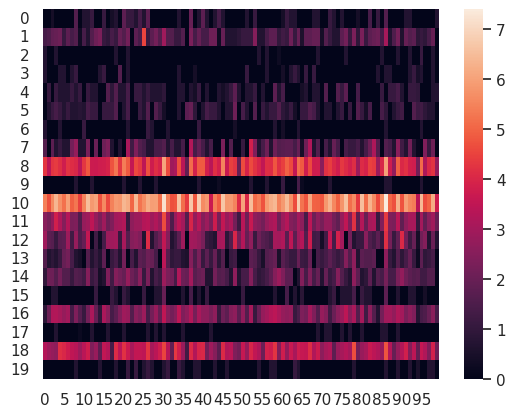

In [190]:
sns.heatmap(prot_df.iloc[:, :100].values)

In [176]:
adata.var["ENSEMBL"][~(adata.var["ENSEMBL"].str[:3] == "ENS")]

Gene_symbol
AAED1         NaN
AC002074.1    NaN
AC002467.1    NaN
AC003092.1    NaN
AC003101.2    NaN
             ... 
WARS          NaN
WDR60         NaN
Z84484.1      NaN
Z98885.3      NaN
ZNF720        NaN
Name: ENSEMBL, Length: 209, dtype: category
Categories (2492, object): ['ENSG00000000971', 'ENSG00000001084', 'ENSG00000001461', 'ENSG00000001629', ..., 'ENSG00000292221', 'ENSG00000292253', 'ENSG00000292288', 'ENSG00000292308']

In [180]:
adata.obs

gene   condition  n_genes  n_genes_by_counts  total_counts  \
Cell_barcodes                                                                   
CELL_211753       SHMT2  Co-culture     2636               2636  14014.001953   
CELL_30576        NMRK1     Control     4576               4576  21455.412109   
CELL_204814       HLA-E  Co-culture     3480               3480  17368.550781   
CELL_95797     SERPINE2        IFNγ     3056               3056  16008.416992   
CELL_138772        SGK1        IFNγ     3704               3704  18466.984375   
...                 ...         ...      ...                ...           ...   
CELL_98948       XAGE1A        IFNγ     3063               3063  16088.213867   
CELL_156372    SLC25A13  Co-culture     3555               3555  17540.615234   
CELL_96795        ACSL3        IFNγ     2387               2387  13378.475586   
CELL_151579        CD63  Co-culture     4315               4315  20427.328125   
CELL_36515      TSC22D3     Control     4586               4586  21588.416016   

               total_counts_mt  pct_counts_mt leiden  mixscape_class_p_ko  \
Cell_barcodes                                                               
CELL_211753          88.033241       0.628181      5                  0.0   
CELL_30576           91.185776       0.425001      0                  0.0   
CELL_204814          93.374641       0.537608      1                  0.0   
CELL_95797           85.809471       0.536027      3                  0.0   
CELL_138772          96.923874       0.524849      4                  0.0   
...                        ...            ...    ...                  ...   
CELL_98948           95.980042       0.596586      3                  0.0   
CELL_156372          88.630554       0.505288      1                  0.0   
CELL_96795           82.993141       0.620348      6                  0.0   
CELL_151579          93.876976       0.459566      2                  0.0   
CELL_36515          100.199127       0.464134      0                  0.0   

              mixscape_class mixscape_class_global pertclass  
Cell_barcodes                                                 
CELL_211753         SHMT2 NP                    NP      weak  
CELL_30576          NMRK1 NP                    NP      weak  
CELL_204814         HLA-E NP                    NP      weak  
CELL_95797       SERPINE2 NP                    NP      weak  
CELL_138772          SGK1 NP                    NP      weak  
...                      ...                   ...       ...  
CELL_98948         XAGE1A NP                    NP      weak  
CELL_156372      SLC25A13 NP                    NP      weak  
CELL_96795          ACSL3 NP                    NP      weak  
CELL_151579          CD63 NP                    NP      weak  
CELL_36515        TSC22D3 NP                    NP      weak  

[121223 rows x 12 columns]

In [194]:
sorted(adata.obs["gene"].unique().tolist())

['A2M',
 'ACSL3',
 'ACTA2',
 'AEBP1',
 'AGA',
 'AHCY',
 'AHNAK',
 'APOC2',
 'APOD',
 'APOE',
 'ARMC6',
 'ATP1B1',
 'ATP5MD',
 'B2M',
 'BOLA2',
 'BOLA2B',
 'BZW2',
 'C19orf48',
 'C1QBP',
 'C6orf226',
 'CCND1',
 'CCND2',
 'CCR10',
 'CCT3',
 'CCT6A',
 'CD151',
 'CD274',
 'CD44',
 'CD47',
 'CD58',
 'CD59',
 'CD63',
 'CDC123',
 'CDH19',
 'CDK4',
 'CDK6',
 'CDKN1A',
 'CDKN2A',
 'CDKN2B',
 'CGAS',
 'CHCHD2',
 'CITED1',
 'CKS1B',
 'CMSS1',
 'CORO1A',
 'CSPG4',
 'CST3',
 'CTPS1',
 'CTRL',
 'CTSA',
 'CTSB',
 'CTSD',
 'CTSL',
 'CTSO',
 'CXCR4',
 'CYP27A1',
 'DAG1',
 'DDR1',
 'DDX17',
 'DDX39A',
 'DLL3',
 'DNMT1',
 'E2F1',
 'EEA1',
 'EEF1G',
 'EIF3K',
 'EIF4A1',
 'EMP1',
 'ENPP1',
 'EVA1A',
 'FARSA',
 'FBL',
 'FBXO32',
 'FGFR1',
 'FKBP4',
 'FMN1',
 'FOS',
 'FOXM1',
 'FRZB',
 'FSTL3',
 'FTH1',
 'GAA',
 'GAS5',
 'GPATCH4',
 'GPI',
 'GPNMB',
 'GRN',
 'GSEC',
 'GSN',
 'HASPIN',
 'HLA-A',
 'HLA-B',
 'HLA-C',
 'HLA-DRB5',
 'HLA-E',
 'HLA-F',
 'HLA-H',
 'HNRNPA1',
 'HNRNPC',
 'HSPA1A',
 'IDH2',
 'IDI2-AS

In [178]:
adata.obs["mixscape_class_global"].unique()

['NP', 'CTRL', 'KO']
Categories (3, object): ['CTRL', 'KO', 'NP']

In [183]:
adata.obs["mixscape_class_p_ko"].sample(100)

Cell_barcodes
CELL_143096    0.000000
CELL_144857    0.000000
CELL_41818     0.000000
CELL_25810     0.000000
CELL_155589    0.000000
                 ...   
CELL_153476    0.000000
CELL_95796     0.000000
CELL_159777    0.000000
CELL_144907    0.849727
CELL_117281    0.000000
Name: mixscape_class_p_ko, Length: 100, dtype: float64

<Axes: >

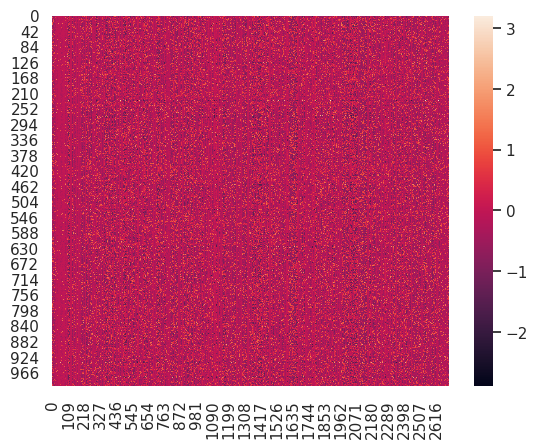

In [9]:
sns.heatmap(adata.to_df().sample(1000).values)

<Axes: ylabel='Count'>

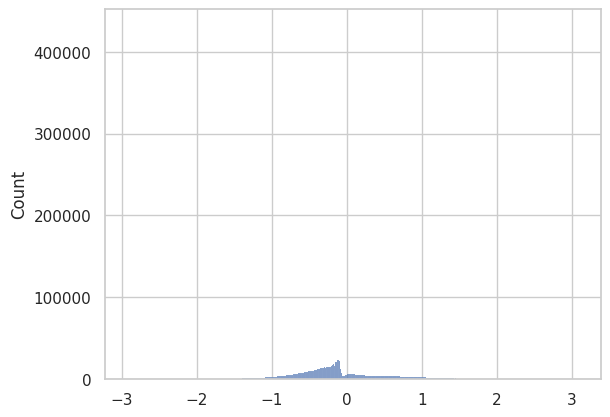

In [10]:
sns.histplot(adata.to_df().sample(1000).values.flatten())

In [11]:
adata.X = adata.layers["normal_counts"].copy()
adata

AnnData object with n_obs × n_vars = 121223 × 2701
    obs: 'gene', 'condition', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'mixscape_class_p_ko', 'mixscape_class', 'mixscape_class_global', 'pertclass'
    var: 'ENSEMBL', 'ENTREZID', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'log1p', 'mixscape', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_pert', 'normal_counts'
    obsp: 'connectivities', 'distances'

<Axes: >

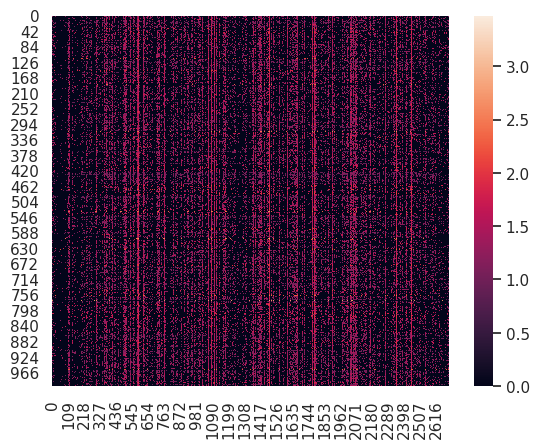

In [164]:
sns.heatmap(adata.to_df().sample(1000).values)

In [12]:
adata.obs["mixscape_class"].unique()

['SHMT2 NP', 'NMRK1 NP', 'HLA-E NP', 'SERPINE2 NP', 'SGK1 NP', ..., 'CCT3 KO', 'NCL KO', 'TRIM22 KO', 'FTH1 KO', 'PYGB KO']
Length: 241
Categories (241, object): ['A2M NP', 'ACSL3 NP', 'ACTA2 NP', 'AEBP1 NP', ..., 'VDAC2 NP', 'WBP2 NP', 'WNT7A NP', 'XAGE1A NP']

In [13]:
# random_samples = np.random.choice(adata.obs_names, size=10000, replace=False)
# random_features = np.random.choice(adata.var_names, size=3000, replace=False)
# # adata = adata[random_samples, :].copy()
# adata

In [14]:
hallmark_collection = muvi.fs.from_gmt(
    "../msigdb/h.all.v7.5.1.symbols.gmt", name="hallmark"
)
reactome_collection = muvi.fs.from_gmt(
    "../msigdb/c2.cp.reactome.v7.5.1.symbols.gmt", name="reactome"
)
# merge both collections
gene_set_collection = hallmark_collection | reactome_collection
gene_set_collection

<FeatureSets 'hallmark|reactome' with 1665 feature sets>

We keep only those gene set annotations with at least 40 genes, and where at least 20% of the genes are available in the set of genes from RNA.

In [15]:
gene_set_collection = gene_set_collection.filter(
    adata.var_names, min_fraction=0.2, min_count=20
)
gene_set_collection

<FeatureSets 'hallmark|reactome' with 78 feature sets>

In [16]:
def prettify(name, max_len=50):
    def prettify_single(name, max_len):
        if "dense" in name:
            return name
        parts = name.split("_")[1:]
        new_name = " ".join(parts)
        if len(new_name) > max_len:
            half_len = (max_len) // 2
            new_name = new_name[: half_len - 2] + "..." + new_name[-half_len + 1 :]
        new_name = f"{new_name} ({name[0]})"
        return new_name.title()

    parts = name.split("|")
    max_len = max_len // len(parts)
    return "|".join([prettify_single(part, max_len) for part in parts])

for gs in gene_set_collection:
    gs.name = prettify(gs.name)

In [17]:
adata.varm["gene_set_mask"] = gene_set_collection.to_mask(adata.var_names.tolist()).T
adata.varm["gene_set_mask"].shape

(2701, 78)

In [18]:
cond_cov = pd.get_dummies(adata.obs["gene"]) * 1.0
cond_cov

A2M  ACSL3  ACTA2  AEBP1  AGA  AHCY  AHNAK  APOC2  APOD  APOE  \
Cell_barcodes                                                                  
CELL_211753    0.0    0.0    0.0    0.0  0.0   0.0    0.0    0.0   0.0   0.0   
CELL_30576     0.0    0.0    0.0    0.0  0.0   0.0    0.0    0.0   0.0   0.0   
CELL_204814    0.0    0.0    0.0    0.0  0.0   0.0    0.0    0.0   0.0   0.0   
CELL_95797     0.0    0.0    0.0    0.0  0.0   0.0    0.0    0.0   0.0   0.0   
CELL_138772    0.0    0.0    0.0    0.0  0.0   0.0    0.0    0.0   0.0   0.0   
...            ...    ...    ...    ...  ...   ...    ...    ...   ...   ...   
CELL_98948     0.0    0.0    0.0    0.0  0.0   0.0    0.0    0.0   0.0   0.0   
CELL_156372    0.0    0.0    0.0    0.0  0.0   0.0    0.0    0.0   0.0   0.0   
CELL_96795     0.0    1.0    0.0    0.0  0.0   0.0    0.0    0.0   0.0   0.0   
CELL_151579    0.0    0.0    0.0    0.0  0.0   0.0    0.0    0.0   0.0   0.0   
CELL_36515     0.0    0.0    0.0    0.0  0.0   0.0    0.0    0.0   0.0   0.0   

               ...  UBA52  UBC  UCN2  UQCRFS1  UQCRH  VAT1  VDAC2  WBP2  \
Cell_barcodes  ...                                                        
CELL_211753    ...    0.0  0.0   0.0      0.0    0.0   0.0    0.0   0.0   
CELL_30576     ...    0.0  0.0   0.0      0.0    0.0   0.0    0.0   0.0   
CELL_204814    ...    0.0  0.0   0.0      0.0    0.0   0.0    0.0   0.0   
CELL_95797     ...    0.0  0.0   0.0      0.0    0.0   0.0    0.0   0.0   
CELL_138772    ...    0.0  0.0   0.0      0.0    0.0   0.0    0.0   0.0   
...            ...    ...  ...   ...      ...    ...   ...    ...   ...   
CELL_98948     ...    0.0  0.0   0.0      0.0    0.0   0.0    0.0   0.0   
CELL_156372    ...    0.0  0.0   0.0      0.0    0.0   0.0    0.0   0.0   
CELL_96795     ...    0.0  0.0   0.0      0.0    0.0   0.0    0.0   0.0   
CELL_151579    ...    0.0  0.0   0.0      0.0    0.0   0.0    0.0   0.0   
CELL_36515     ...    0.0  0.0   0.0      0.0    0.0   0.0    0.0   0.0   

               WNT7A  XAGE1A  
Cell_barcodes                 
CELL_211753      0.0     0.0  
CELL_30576       0.0     0.0  
CELL_204814      0.0     0.0  
CELL_95797       0.0     0.0  
CELL_138772      0.0     0.0  
...              ...     ...  
CELL_98948       0.0     1.0  
CELL_156372      0.0     0.0  
CELL_96795       0.0     0.0  
CELL_151579      0.0     0.0  
CELL_36515       0.0     0.0  

[121223 rows x 242 columns]

## Informed Latent Decomposition

For this analysis we use the prior information from [Reactome](https://reactome.org/) which has already been stored inside `adata.varm['gene_set_mask']`.

In [19]:
model = muvi.tl.from_adata(
    adata,
    prior_mask_key="gene_set_mask",
    view_names=["rna"],
    prior_confidence="med",
    n_factors=1,
    condition_covs=cond_cov.values,
    nmf=True,
    device=device,
)
model

2025-02-27 19:25:23,599 - muvi.core.models - WARNING - Running MuVI on a single view.
2025-02-27 19:25:23,601 - muvi.core.models - INFO - pd.DataFrame detected.
2025-02-27 19:25:23,602 - muvi.core.models - INFO - Storing the index of the view `rna` as sample names.
2025-02-27 19:25:23,619 - muvi.core.models - INFO - pd.DataFrame detected.
2025-02-27 19:25:23,623 - muvi.core.models - INFO - pd.DataFrame detected.
2025-02-27 19:25:23,627 - muvi.core.models - INFO - Storing the index of the mask `rna` as factor names.
2025-02-27 19:25:23,630 - muvi.core.models - INFO - Likelihoods set to `{'rna': 'normal'}`.
2025-02-27 19:25:23,631 - muvi.core.models - INFO - NMF set to `{'rna': True}`.
2025-02-27 19:25:23,631 - muvi.core.models - INFO - Normalizing observations.
2025-02-27 19:25:23,632 - muvi.core.models - INFO - Setting min value of view `rna` to 0.
2025-02-27 19:25:26,070 - muvi.core.models - INFO - Setting global standard deviation to 1.0 (from 0.623).
2025-02-27 19:25:26,180 - muvi.c

|================================|
|       MuVI version 0.2.0       |
|================================|
| Parameter        | Value       |
|------------------|-------------|
| n_views          | 1           |
| n_samples        | 121223      |
| n_features       | rna: 2701   |
| n_factors        | 79          |
| prior_confidence | 0.995       |
| n_covariates     | 0           |
| likelihoods      | rna: normal |
| nmf              | rna: True   |
| reg_hs           | True        |
| pos_transform    | relu        |
| device           | cuda:1      |
|================================|

In [20]:
# _, training_data = model.fit(seed=0, batch_size=1000, n_epochs=200)
# training_data = {k: v.to(model.device) for k, v in training_data.items()}
# training_data["sample_idx"] = None
# pyro.render_model(model._model, model_kwargs=training_data)

In [21]:
model.fit(seed=0, batch_size=10000)

2025-02-27 19:25:26,277 - muvi.core.models - INFO - Preparing model and guide...
2025-02-27 19:25:26,349 - muvi.core.models - INFO - Preparing optimizer...
2025-02-27 19:25:26,350 - muvi.core.models - INFO - Decaying learning rate over 9996 iterations.
2025-02-27 19:25:26,351 - muvi.core.models - INFO - Preparing SVI...
2025-02-27 19:25:26,352 - muvi.core.models - INFO - Preparing training data...
2025-02-27 19:25:26,729 - muvi.core.models - INFO - Using batches of size `10000`.
2025-02-27 19:25:26,731 - muvi.core.models - INFO - Setting training seed to `0`.
2025-02-27 19:25:26,740 - muvi.core.models - INFO - Cleaning parameter store.
2025-02-27 19:25:26,741 - muvi.core.models - INFO - Starting training...


  0%|                                                   | 0/833 [00:00<?, ?it/s]

2025-02-27 19:25:28,257 - root - INFO - Guessed max_plate_nesting = 2


100%|███████████████████████████| 833/833 [37:02<00:00,  2.67s/it, ELBO=3.65e+4]

2025-02-27 20:02:28,882 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.


## Downstream Analysis

Once the training terminates, we may call `muvi.tl.foo` followed by `muvi.pl.foo` to apply different analysis tools and plot the results, similar to the usage principles of `scanpy`.

Under the hood, `muvi` stores every intermediate result in a `model._cache.factor_adata` such as variance explained by each factor, significance of each factor with respect to the prior information and so on.

In [22]:
# to speed up the process, use a random subsample to approximate the variance explained
r2_view, r2_factor, _ = muvi.tl.variance_explained(model, subsample=1000)
r2_view

2025-02-27 20:02:29,912 - muvi.tools.utils - INFO - Estimating `r2` with a random sample of 1000 samples.
2025-02-27 20:02:29,962 - muvi.tools.utils - WARNING - Cache has not yet been setup, initialising model cache.


/home/aqoku/miniforge3/envs/muvi_ext/lib/python3.10/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


{'rna': np.float32(0.57037747)}

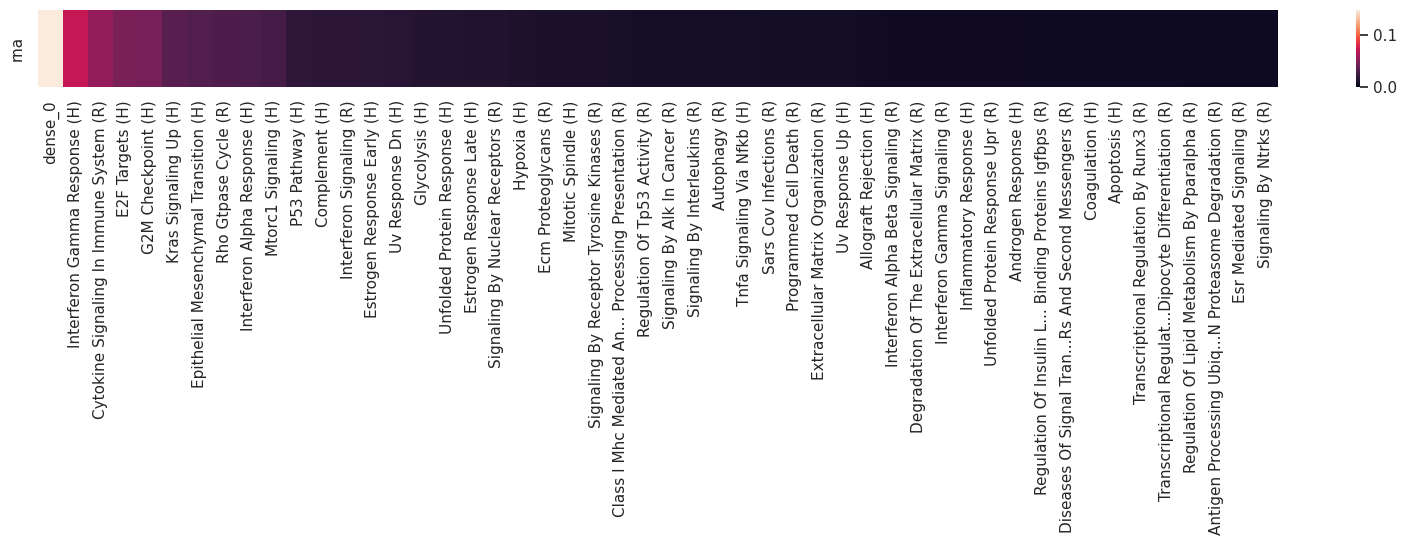

<Axes: >

In [23]:
muvi.pl.variance_explained(model)

Next, we perform a statistical test ([PCGSE](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4543476/)) to determine how well the inferred factors match the prior information representing each pathway. Here, we apply a correlation adjusted one-sided t-test, and correcting for multiple testing. 

Unless we provide other feature sets, e.g. [Gene Ontology](http://geneontology.org/), `muvi` automatically compares each inferred factor against its corresponding prior gene set annotation.

In [24]:
_ = muvi.tl.test(model)

2025-02-27 20:02:33,494 - muvi.tools.utils - WARNING - No feature sets provided for `rna`, extracting feature sets from the prior mask.


100%|███████████████████████████████████████████| 78/78 [00:01<00:00, 60.37it/s]

2025-02-27 20:02:34,873 - muvi.tools.utils - WARNING - No feature sets provided for `rna`, extracting feature sets from the prior mask.




00%|███████████████████████████████████████████| 78/78 [00:01<00:00, 51.07it/s]

Now we may plot an overview of the most relevant factors by combining the variance explained and the results of the statistical test. Since we applied a one-sided hypothesis test, each significant factor is marked by a `(+)` or `(-)` indicating the significance direction. A factor may also be significant in both directions. However, we report the more significant direction based on the lower p-value.

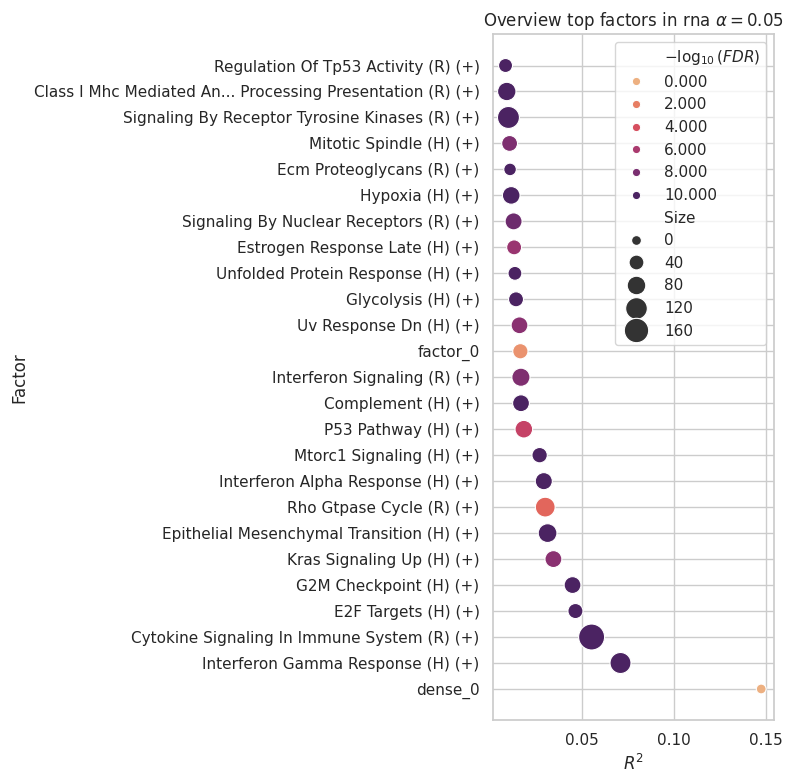

(<Figure size 800x800 with 1 Axes>,
 array([[<Axes: title={'center': 'Overview top factors in rna $\\alpha = 0.05$'}, xlabel='$R^2$', ylabel='Factor'>]],
       dtype=object))

In [25]:
muvi.pl.factors_overview(model)

In [26]:
# add obs metadata
model._cache.factor_adata.obs = adata.obs.copy()

After copying the metadata stored in `adata.obs`, we may perform a typical `scanpy` analysis such as computing a neighborhood graph in the latent space, applying a clustering algorithm on the pathway level, and embedding the neighborhood graph in two dimensions for visualization purposes.

Optionally, we may filter only the relevant factors before performing the steps mentioned above. This is useful to reduce the number of factors involved in the analysis by removing factors that explain little to no variance in the data.

In [27]:
muvi.tl.filter_factors(model)

2025-02-27 20:02:37,306 - muvi.tools.utils - INFO - Filtering down to 60 factors.
2025-02-27 20:02:37,355 - muvi.tools.cache - INFO - Factors filtered successfully.


True

In [28]:
model._cache.factor_adata.obs

gene   condition  n_genes  n_genes_by_counts  total_counts  \
Cell_barcodes                                                                   
CELL_211753       SHMT2  Co-culture     2636               2636  14014.001953   
CELL_30576        NMRK1     Control     4576               4576  21455.412109   
CELL_204814       HLA-E  Co-culture     3480               3480  17368.550781   
CELL_95797     SERPINE2        IFNγ     3056               3056  16008.416992   
CELL_138772        SGK1        IFNγ     3704               3704  18466.984375   
...                 ...         ...      ...                ...           ...   
CELL_98948       XAGE1A        IFNγ     3063               3063  16088.213867   
CELL_156372    SLC25A13  Co-culture     3555               3555  17540.615234   
CELL_96795        ACSL3        IFNγ     2387               2387  13378.475586   
CELL_151579        CD63  Co-culture     4315               4315  20427.328125   
CELL_36515      TSC22D3     Control     4586               4586  21588.416016   

               total_counts_mt  pct_counts_mt leiden  mixscape_class_p_ko  \
Cell_barcodes                                                               
CELL_211753          88.033241       0.628181      5                  0.0   
CELL_30576           91.185776       0.425001      0                  0.0   
CELL_204814          93.374641       0.537608      1                  0.0   
CELL_95797           85.809471       0.536027      3                  0.0   
CELL_138772          96.923874       0.524849      4                  0.0   
...                        ...            ...    ...                  ...   
CELL_98948           95.980042       0.596586      3                  0.0   
CELL_156372          88.630554       0.505288      1                  0.0   
CELL_96795           82.993141       0.620348      6                  0.0   
CELL_151579          93.876976       0.459566      2                  0.0   
CELL_36515          100.199127       0.464134      0                  0.0   

              mixscape_class mixscape_class_global pertclass  
Cell_barcodes                                                 
CELL_211753         SHMT2 NP                    NP      weak  
CELL_30576          NMRK1 NP                    NP      weak  
CELL_204814         HLA-E NP                    NP      weak  
CELL_95797       SERPINE2 NP                    NP      weak  
CELL_138772          SGK1 NP                    NP      weak  
...                      ...                   ...       ...  
CELL_98948         XAGE1A NP                    NP      weak  
CELL_156372      SLC25A13 NP                    NP      weak  
CELL_96795          ACSL3 NP                    NP      weak  
CELL_151579          CD63 NP                    NP      weak  
CELL_36515        TSC22D3 NP                    NP      weak  

[121223 rows x 12 columns]

Now we can proceed to perform clustering on top of the inferred and filtered latent space.

In [29]:
muvi.tl.neighbors(model)
muvi.tl.leiden(model)
muvi.tl.umap(model)

/home/aqoku/projects/code_new/MuVI/muvi/tools/utils.py:817: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  return cluster_fn(setup_cache(model).factor_adata, **kwargs)


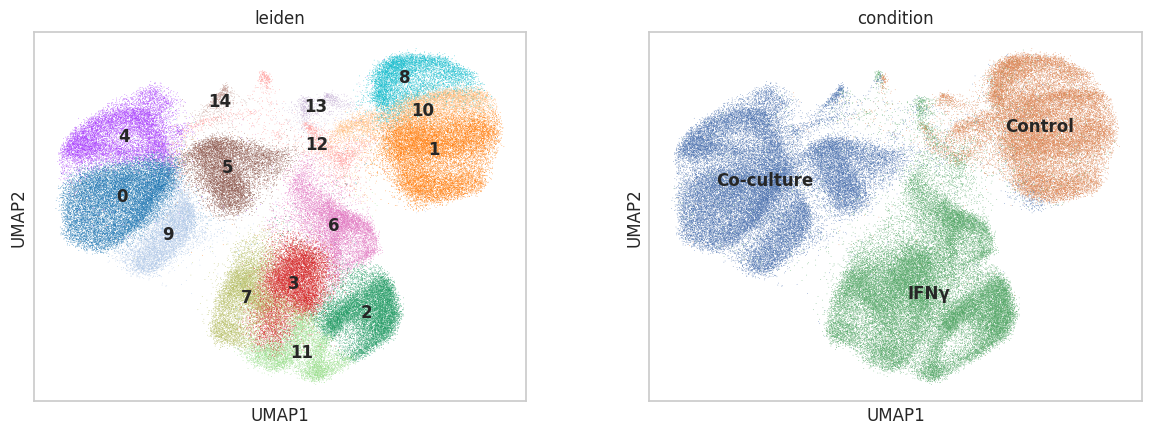

In [30]:
muvi.pl.umap(model, color=["leiden", "condition"], legend_loc="on data")

The inferred latent space captures major axes of variation such as different conditions or cell types. Next, we look into specific factors (pathways) that explain variance between both conditions. 

2025-02-27 20:08:15,924 - muvi.tools.plotting - WARNING - dendrogram data not found (using `dendrogram_condition` as key). Running `muvi.tl.dendrogram` with default parameters. For fine tuning it is recommended to run `muvi.tl.dendrogram` independently.


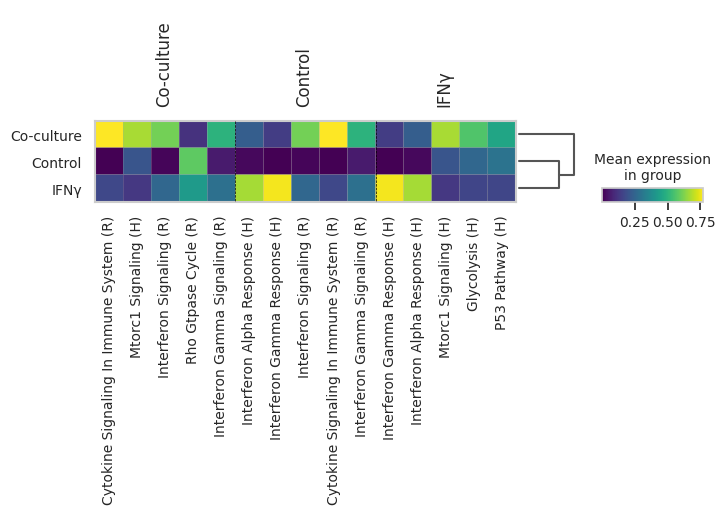

<Axes: >

In [31]:
muvi.tl.rank(model, "condition", method="wilcoxon")
muvi.pl.rank(
    model, n_factors=5, pl_type="matrixplot", swap_axes=False
)

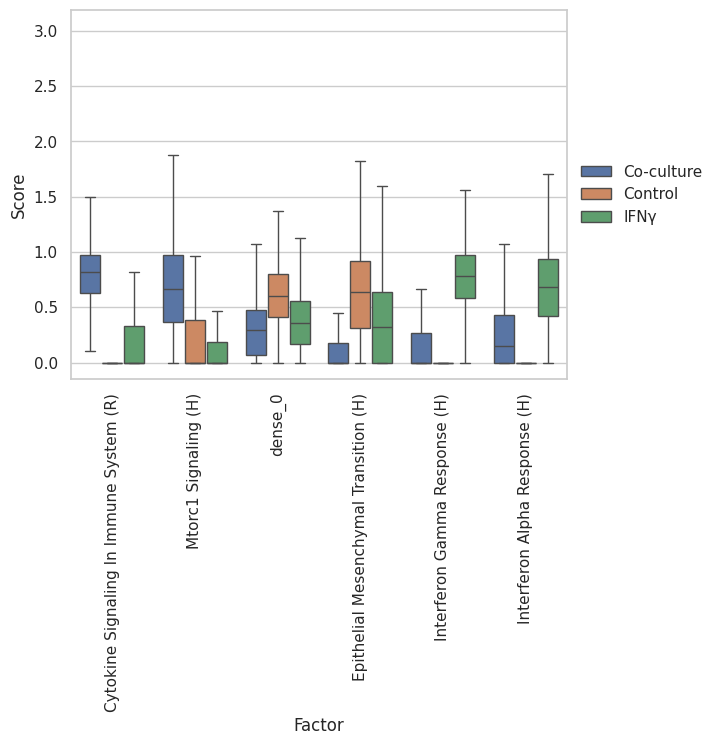

In [62]:
top_cond_factors, _ = muvi.pl.groupplot_rank(model, pl_type="boxplot", top=2, fliersize=0, gap=0.1, rot=90)

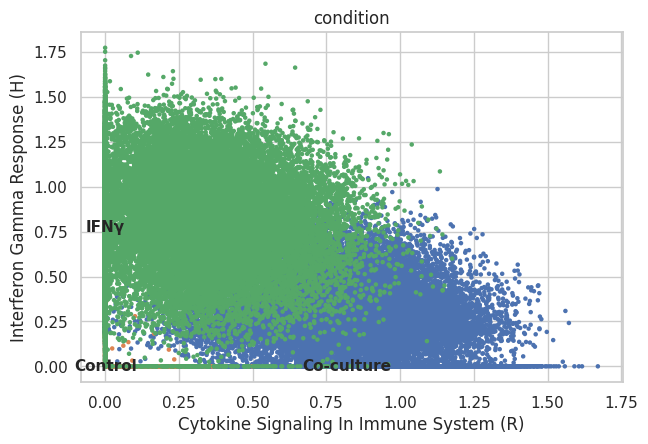

In [63]:
muvi.pl.scatter(
    model,
    "Cytokine Signaling In Immune System (R)",
    "Interferon Gamma Response (H)",
    "condition",
    size=42,
    legend_loc="on data",
)

In [34]:
import pyro

In [35]:
pyro.get_param_store().get_param("MuVI._guide.locs.w_condition").cpu().detach().numpy()[:, model.factor_order].shape

(242, 79)

In [36]:
condition_w = pd.DataFrame(pyro.get_param_store().get_param("MuVI._guide.locs.w_condition").cpu().detach().numpy()[:, model.factor_order].T, index=model.factor_names, columns=cond_cov.columns)
condition_w.head()

A2M     ACSL3     ACTA2  \
dense_0                                  0.000000  0.000000  0.000000   
Interferon Gamma Response (H)            0.239791  0.215492  0.198423   
Cytokine Signaling In Immune System (R)  0.238516  0.226022  0.195090   
E2F Targets (H)                          0.301385  0.159491  0.296710   
G2M Checkpoint (H)                       0.172543  0.057337  0.180959   

                                            AEBP1       AGA      AHCY  \
dense_0                                  0.000000  0.000000  0.000000   
Interferon Gamma Response (H)            0.190356  0.196418  0.123094   
Cytokine Signaling In Immune System (R)  0.234243  0.211534  0.132405   
E2F Targets (H)                          0.265938  0.297926  0.202760   
G2M Checkpoint (H)                       0.163398  0.165206  0.014672   

                                            AHNAK     APOC2      APOD  \
dense_0                                  0.000000  0.000000  0.000000   
Interferon Gamma Response (H)            0.172323  0.222519  0.269335   
Cytokine Signaling In Immune System (R)  0.203775  0.176372  0.199503   
E2F Targets (H)                          0.254751  0.280942  0.276884   
G2M Checkpoint (H)                       0.143527  0.152109  0.132051   

                                             APOE  ...     UBA52       UBC  \
dense_0                                  0.000000  ...  0.000000  0.000000   
Interferon Gamma Response (H)            0.203726  ...  0.179879  0.254754   
Cytokine Signaling In Immune System (R)  0.192966  ...  0.073354  0.223918   
E2F Targets (H)                          0.297148  ...  0.190762  0.360210   
G2M Checkpoint (H)                       0.210964  ...  0.002869  0.208759   

                                             UCN2   UQCRFS1     UQCRH  \
dense_0                                  0.000000  0.000000  0.000000   
Interferon Gamma Response (H)            0.214260  0.163495  0.160928   
Cytokine Signaling In Immune System (R)  0.218375  0.226362  0.178381   
E2F Targets (H)                          0.251268  0.273987  0.279013   
G2M Checkpoint (H)                       0.150593  0.132840  0.180521   

                                             VAT1     VDAC2      WBP2  \
dense_0                                  0.000000  0.000000  0.000000   
Interferon Gamma Response (H)            0.178067  0.200783  0.244758   
Cytokine Signaling In Immune System (R)  0.191684  0.226453  0.221578   
E2F Targets (H)                          0.311763  0.276053  0.300592   
G2M Checkpoint (H)                       0.181615  0.166084  0.213384   

                                            WNT7A    XAGE1A  
dense_0                                  0.000000  0.000000  
Interferon Gamma Response (H)            0.243574  0.211487  
Cytokine Signaling In Immune System (R)  0.171064  0.192976  
E2F Targets (H)                          0.278306  0.258643  
G2M Checkpoint (H)                       0.163591  0.115012  

[5 rows x 242 columns]

In [49]:
relevant_conditions = ["JAK1", "STAT1", "IFNGR2", "JAK2", "IFNGR1", "TXNDC17", "SNRPE", "CTRL", "UBA52", "TMED10", "TPRKB", "FARSA", "SNRPF", "PABPC1", "CCT6A", "SLIRP", "EIF4A1", "NACA", "MYC", "AHCY", "CDK6", "CCND1", "NCL", "SMAD4", "CTPS1", "PTMA"]
len(relevant_conditions)

26

/home/aqoku/miniforge3/envs/muvi_ext/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/aqoku/miniforge3/envs/muvi_ext/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 2000x2000 with 0 Axes>

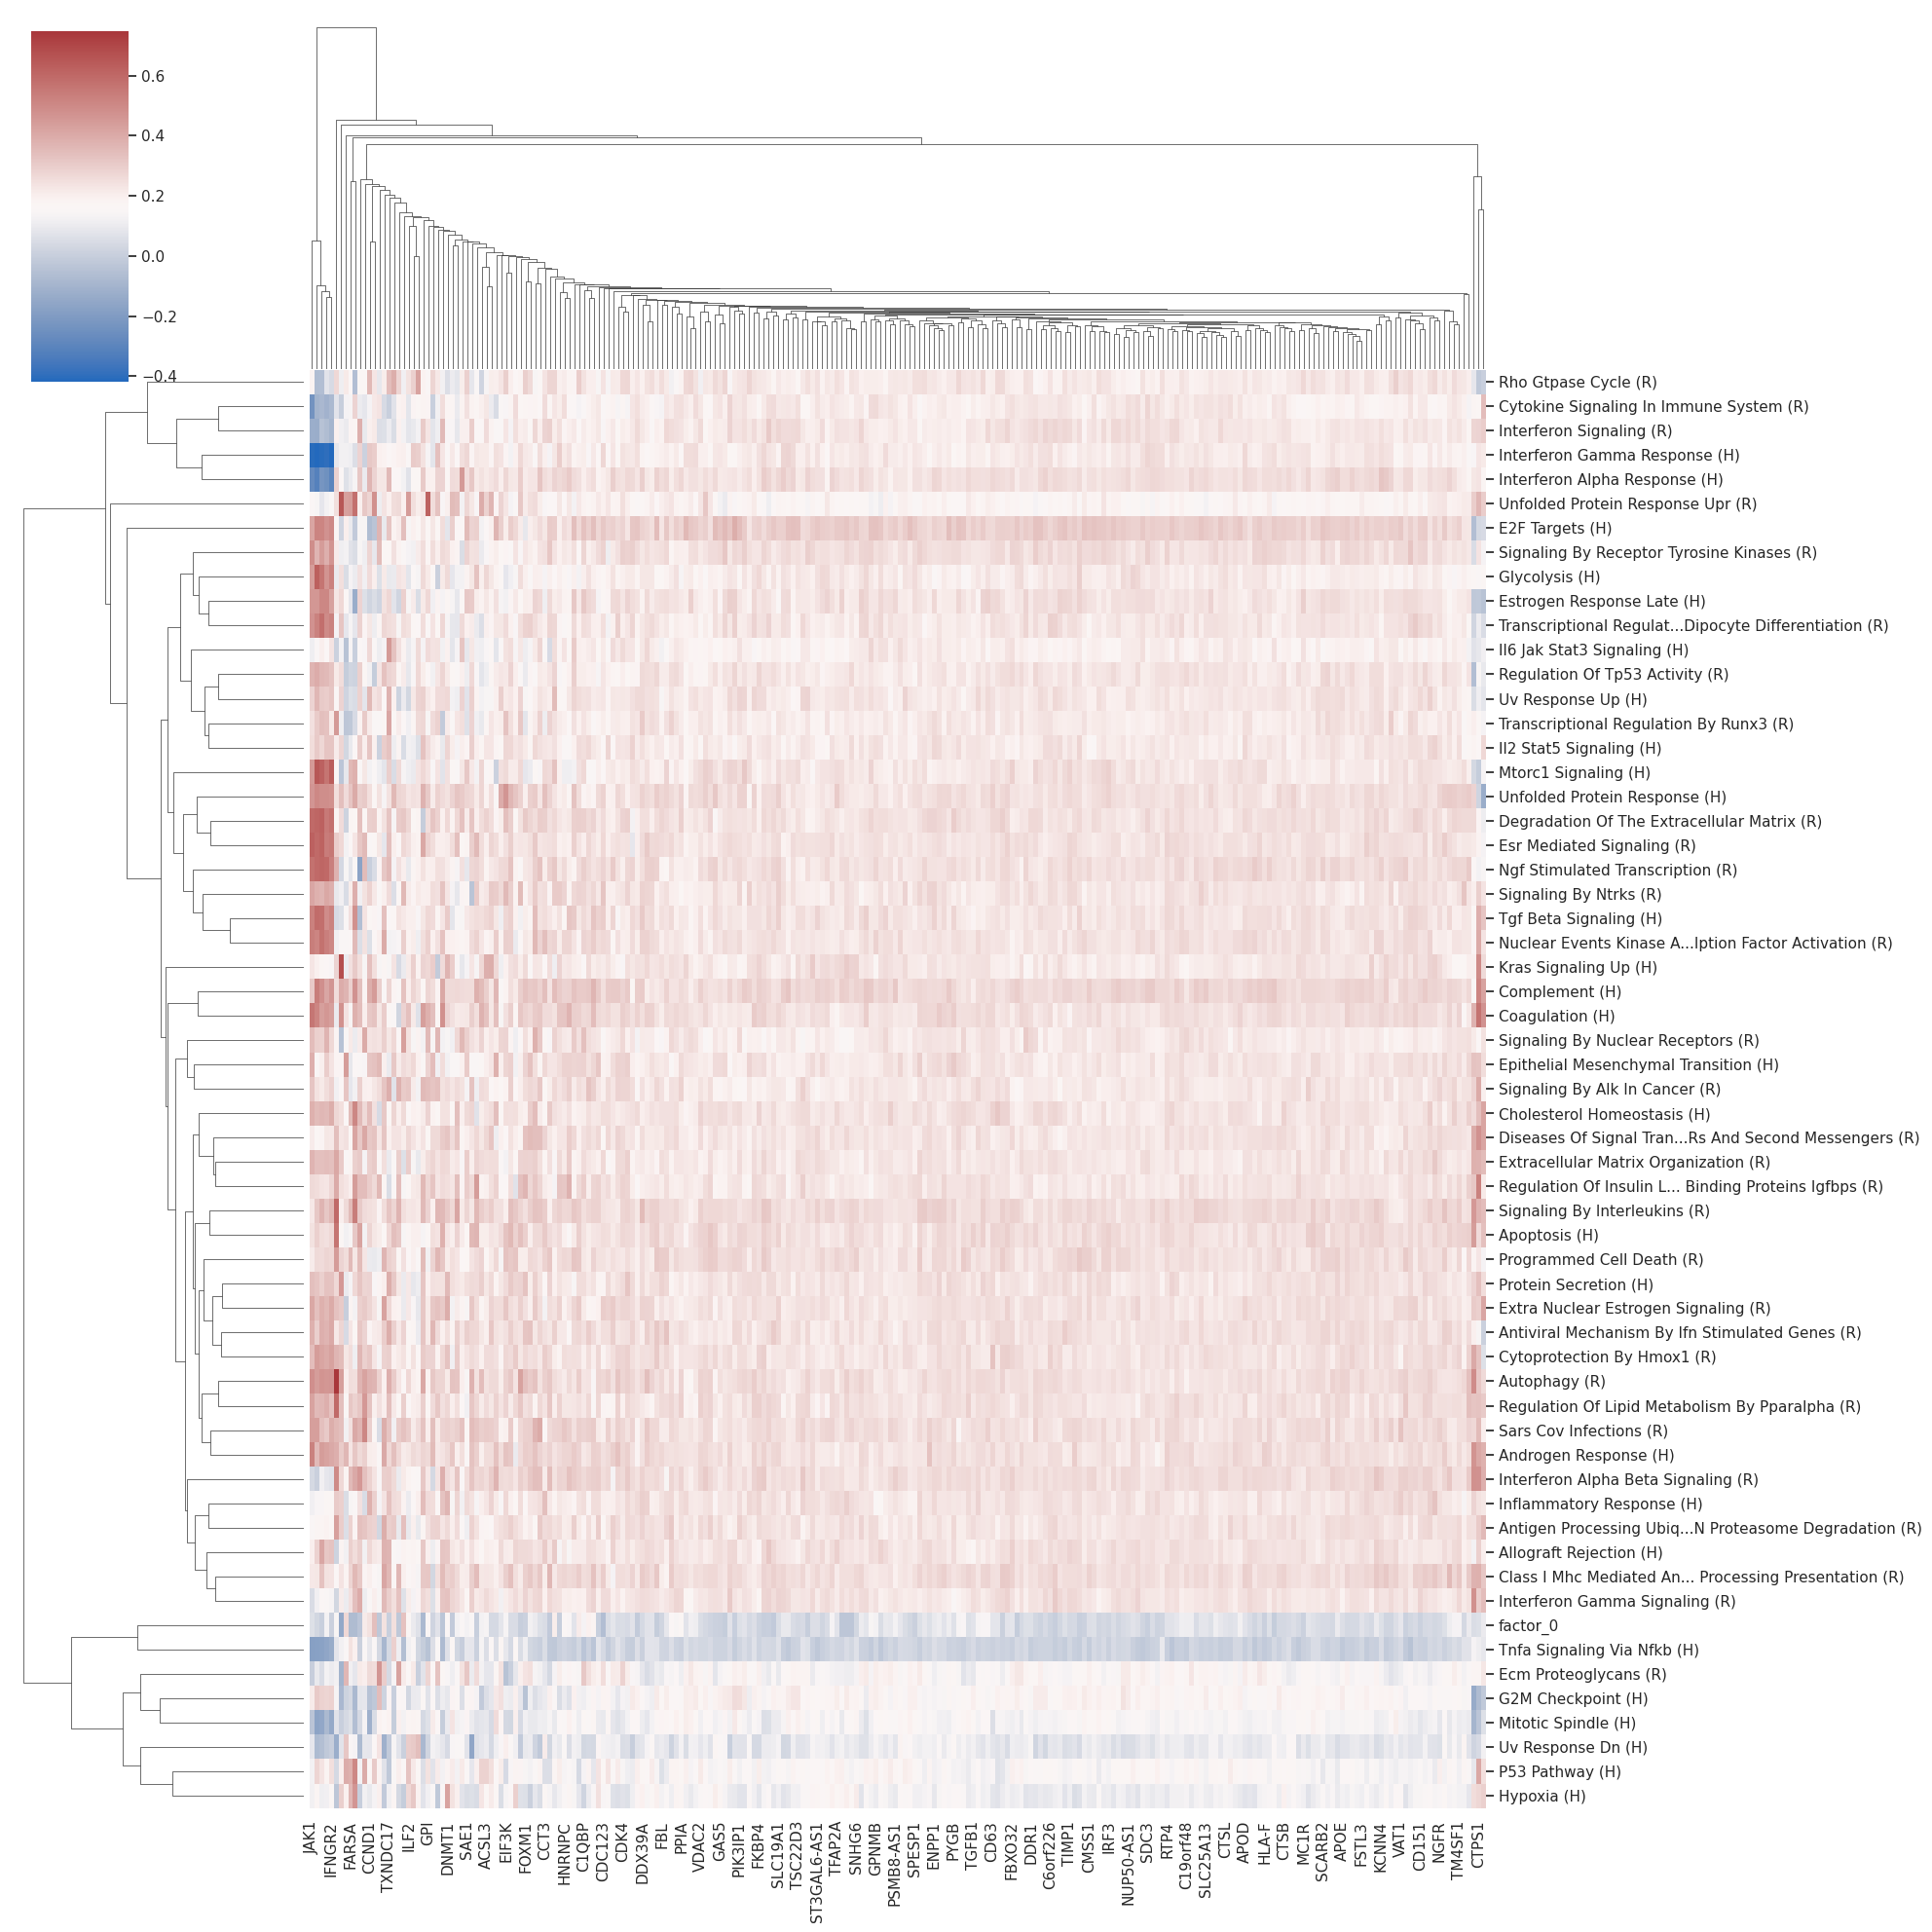

In [100]:
# sns.clustermap(condition_w.iloc[1:21, :], yticklabels=True, xticklabels=True)
plt.figure(figsize=(20, 20))
sns.clustermap(condition_w.loc[model._cache.factor_adata.obsm["filtered_scores"].columns[model.n_dense_factors:], :], figsize=(20, 20), yticklabels=True, cmap=sns.color_palette("vlag", as_cmap=True))

In [50]:
from sklearn.metrics.pairwise import cosine_similarity

In [58]:
# Compute cosine similarity across rows
cols = model._cache.factor_adata.obsm["filtered_scores"].columns[model.n_dense_factors:]

cosine_sim = cosine_similarity(condition_w.loc[cols, :].T)

# Convert to DataFrame for readability
cosine_sim_df = pd.DataFrame(cosine_sim, index=condition_w.columns, columns=condition_w.columns)

A2M     ACSL3     ACTA2     AEBP1       AGA      AHCY     AHNAK  \
A2M    1.000000  0.961405  0.989661  0.989591  0.991494  0.769910  0.990574   
ACSL3  0.961405  1.000000  0.948509  0.953417  0.965316  0.804972  0.970739   
ACTA2  0.989661  0.948509  1.000000  0.987584  0.987725  0.746487  0.987938   
AEBP1  0.989591  0.953417  0.987584  1.000000  0.982806  0.798176  0.987642   
AGA    0.991494  0.965316  0.987725  0.982806  1.000000  0.776495  0.988651   

          APOC2      APOD      APOE  ...     UBA52       UBC      UCN2  \
A2M    0.993492  0.994290  0.992932  ...  0.888747  0.982851  0.989964   
ACSL3  0.960225  0.957592  0.956107  ...  0.869939  0.956946  0.961428   
ACTA2  0.991822  0.989318  0.990817  ...  0.892216  0.974230  0.985296   
AEBP1  0.988059  0.988203  0.987466  ...  0.910412  0.976376  0.990712   
AGA    0.989895  0.988098  0.991233  ...  0.886494  0.981718  0.982431   

        UQCRFS1     UQCRH      VAT1     VDAC2      WBP2     WNT7A    XAGE1A  
A2M    0.979429  0.977779  0.988923  0.988958  0.990629  0.993502  0.989068  
ACSL3  0.961243  0.966247  0.956761  0.965125  0.961735  0.962776  0.962878  
ACTA2  0.969051  0.970115  0.988346  0.982248  0.986127  0.990302  0.990756  
AEBP1  0.977641  0.972635  0.983325  0.986348  0.980238  0.985513  0.982188  
AGA    0.978658  0.978101  0.988636  0.987219  0.988549  0.989910  0.989957  

[5 rows x 242 columns]

/home/aqoku/miniforge3/envs/muvi_ext/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/aqoku/miniforge3/envs/muvi_ext/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


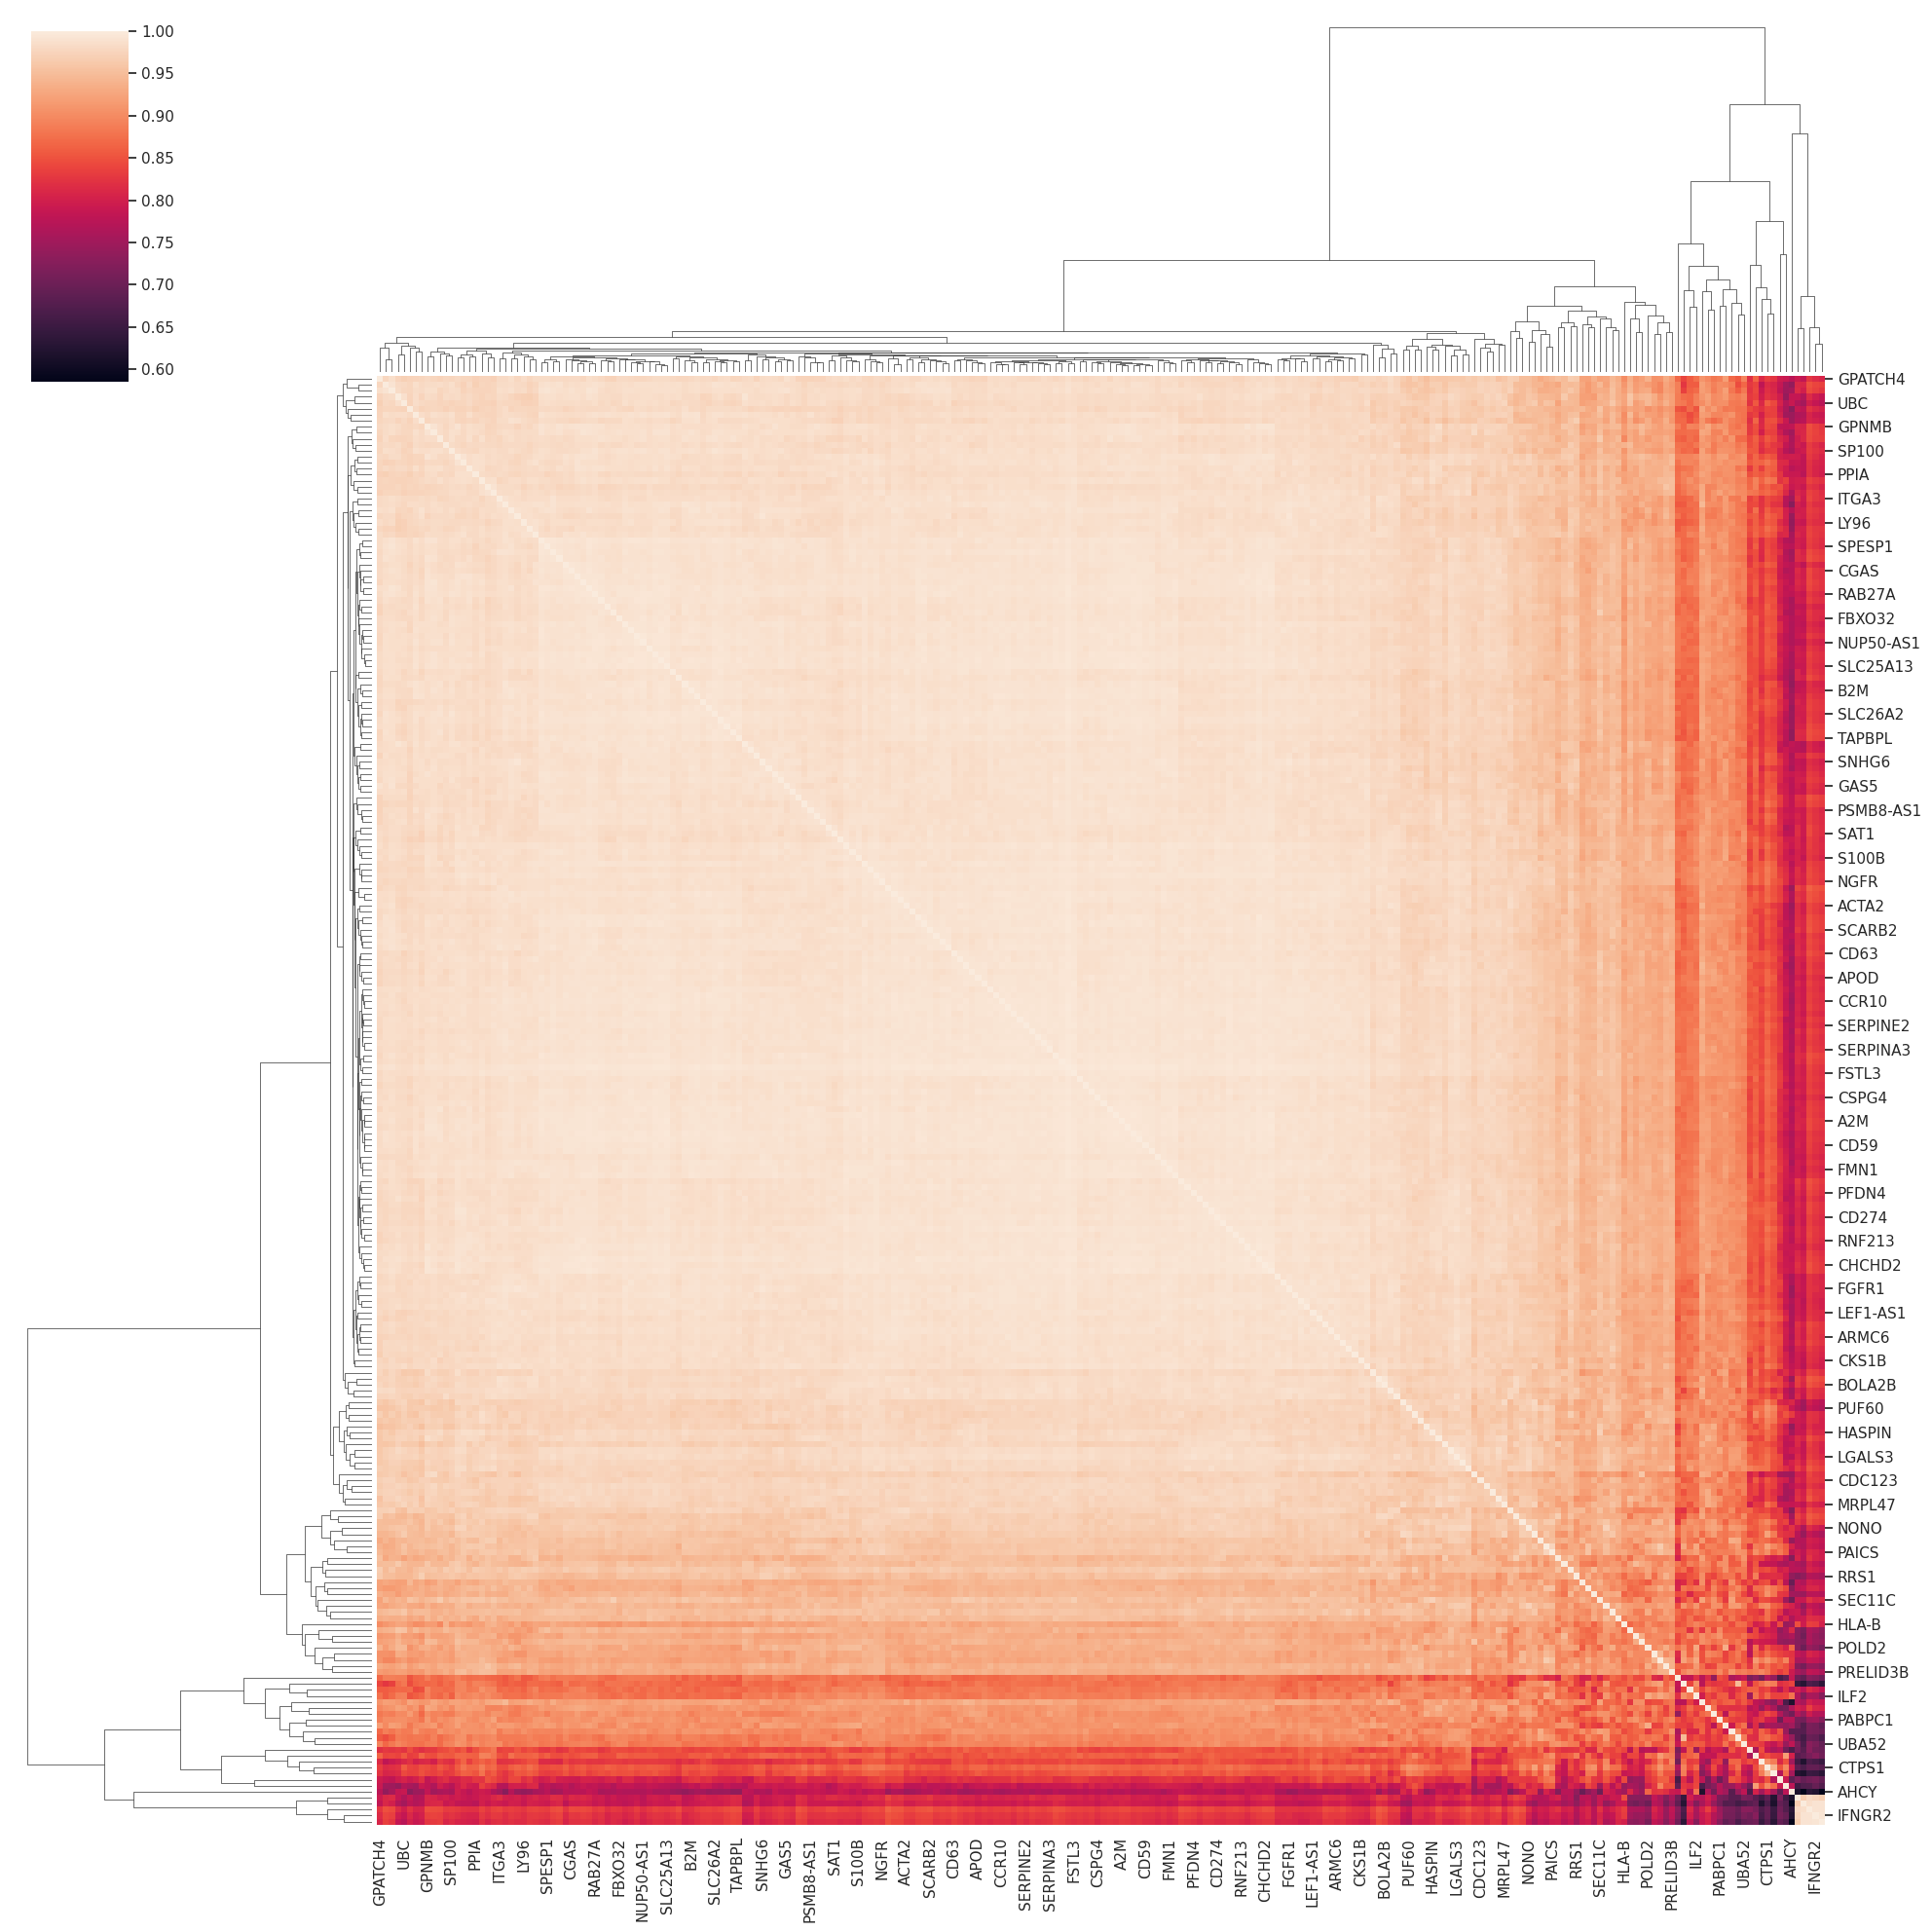

In [104]:
clustergrid = sns.clustermap(cosine_sim_df, figsize=(20, 20))

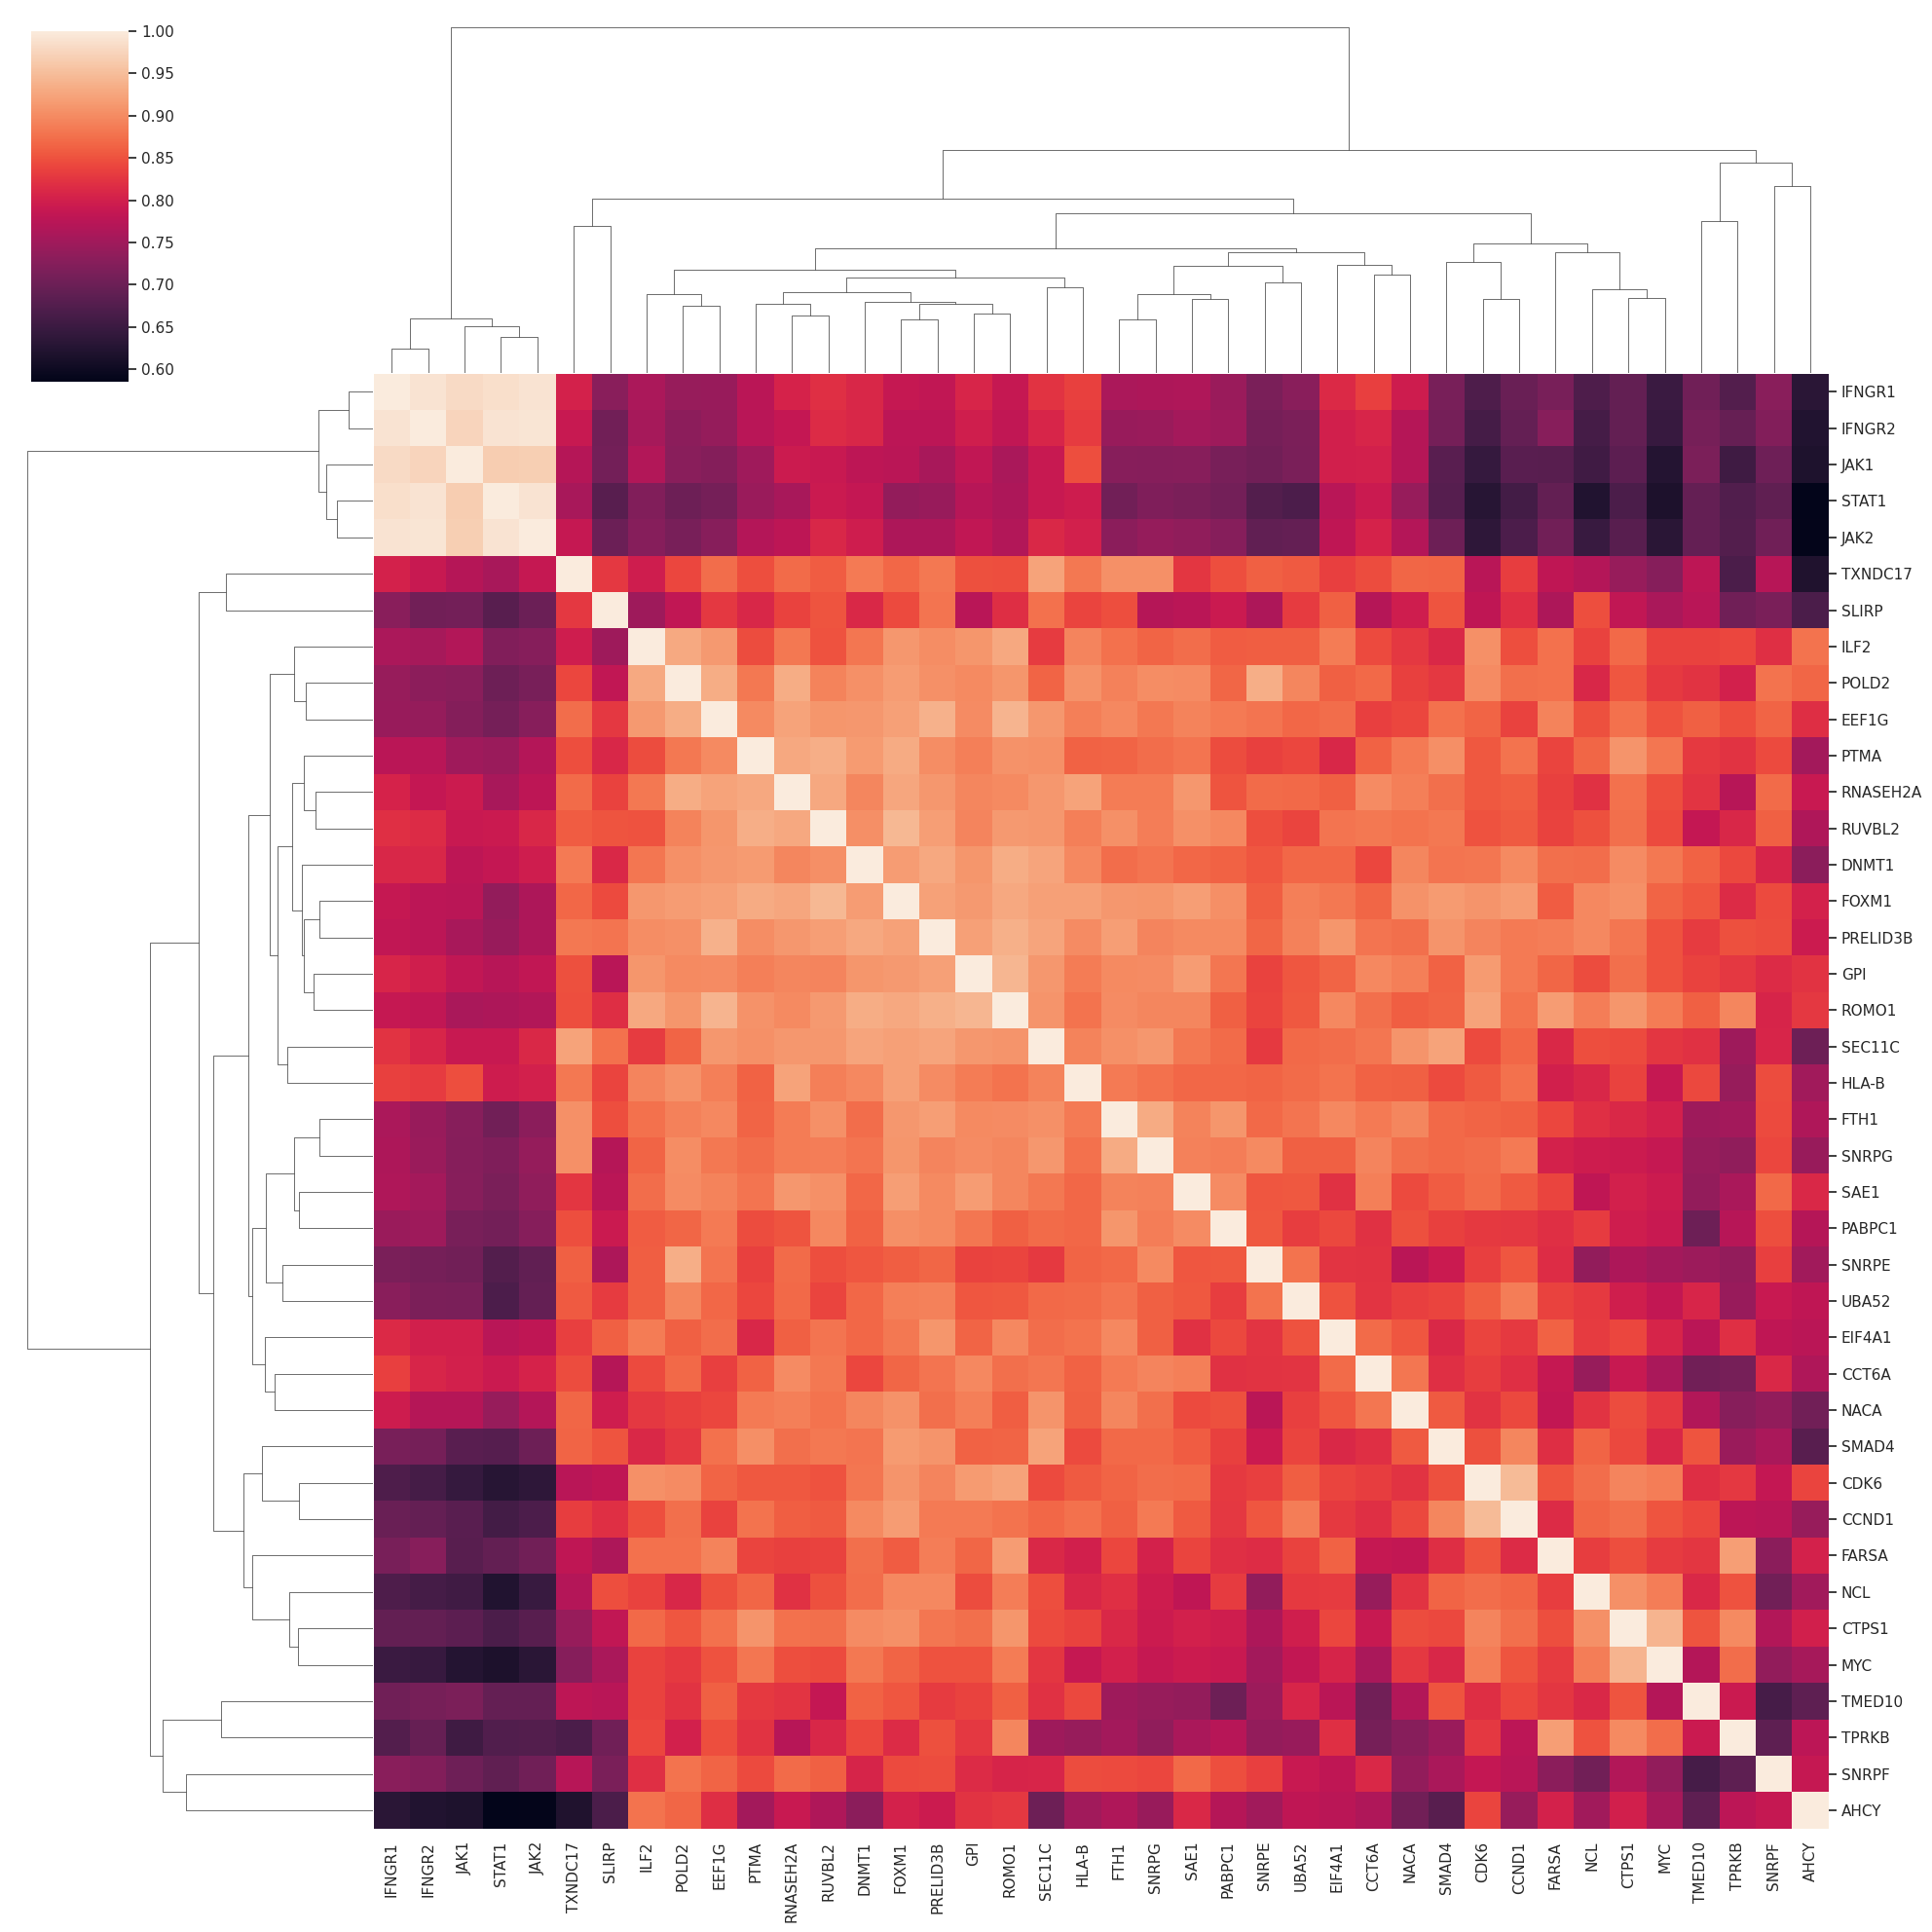

In [114]:
sim_conditions = cosine_sim_df.index[clustergrid.dendrogram_row.reordered_ind][-40:].tolist()
sns.clustermap(cosine_sim_df.loc[sim_conditions, sim_conditions], figsize=(20, 20))

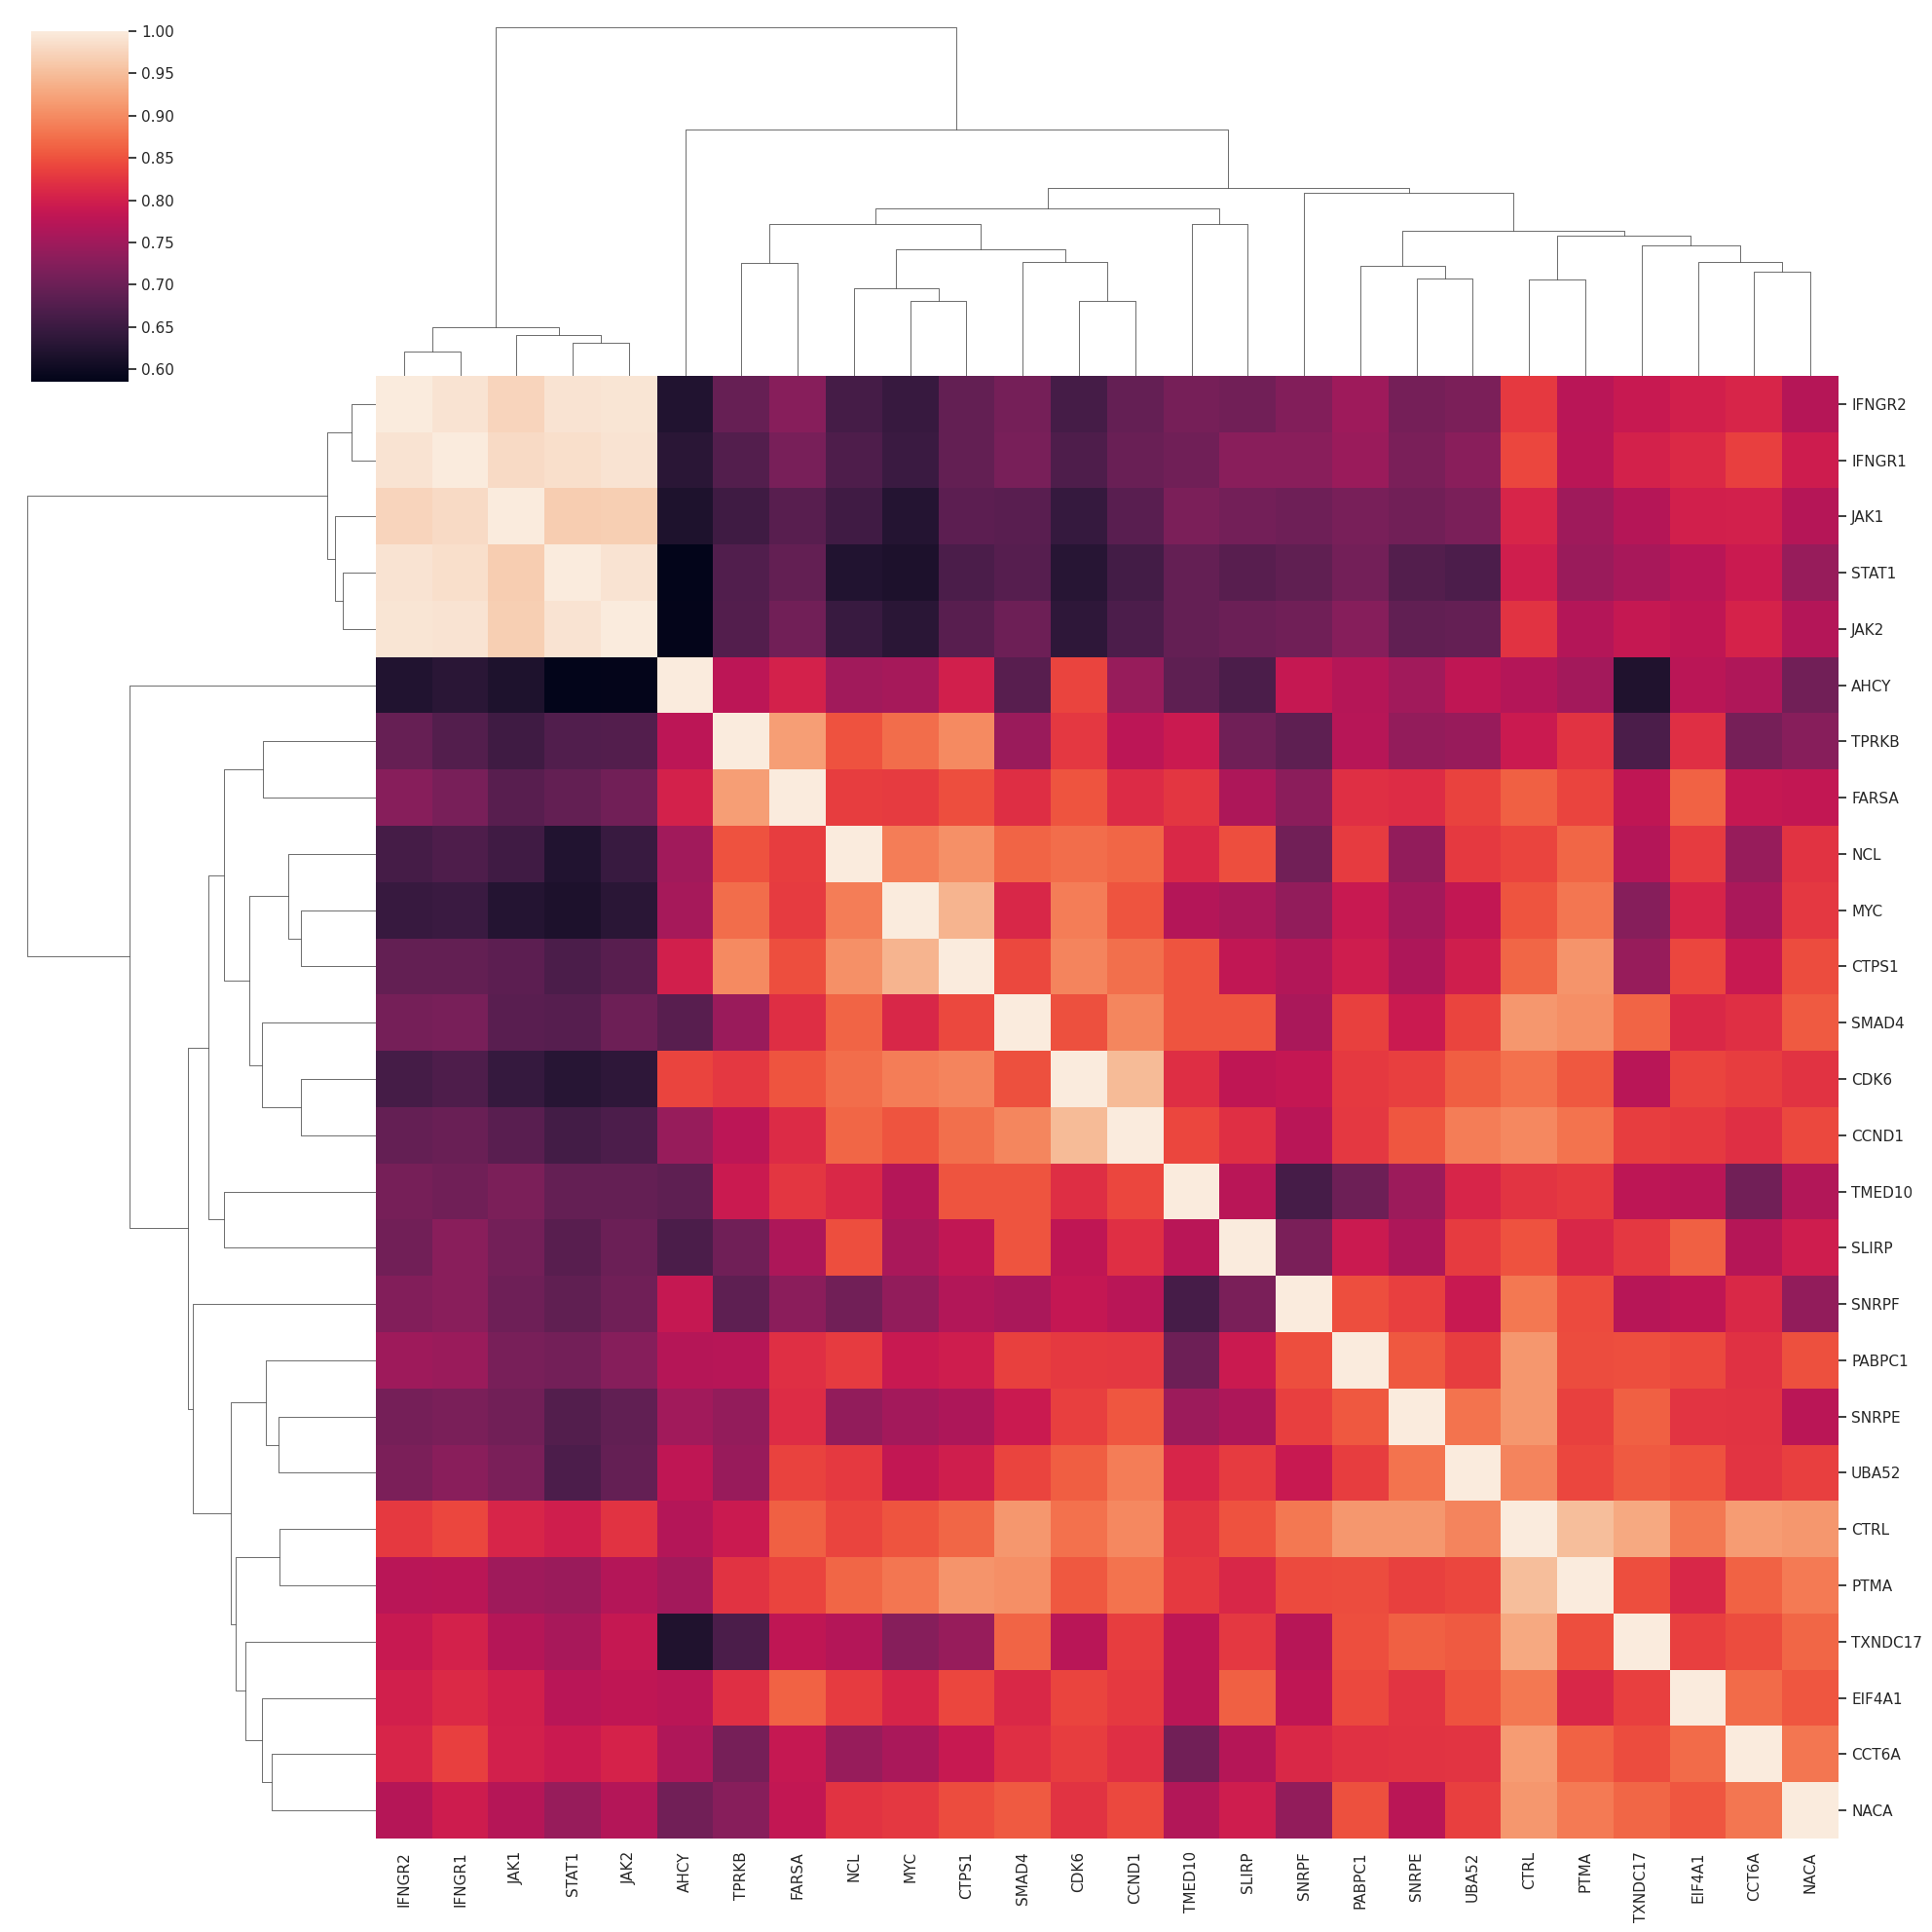

In [115]:
sns.clustermap(cosine_sim_df.loc[relevant_conditions, relevant_conditions], figsize=(20, 20))

In [116]:
# sns.clustermap(condition_w.loc[model._cache.factor_adata.obsm["filtered_scores"].columns[model.n_dense_factors:], :].corr().loc[relevant_conditions, relevant_conditions])

In [84]:
ifn_genes = ["JAK1", "IFNGR1", "JAK2", "STAT1", "IFNGR2"]
model._cache.factor_adata.obs["IFN_gene"] = model._cache.factor_adata.obs["gene"].astype(str)
model._cache.factor_adata.obs.loc[~model._cache.factor_adata.obs["IFN_gene"].isin(ifn_genes), "IFN_gene"] = np.nan
model._cache.factor_adata.obs["IFN_gene"] = model._cache.factor_adata.obs["IFN_gene"].astype("category")

In [85]:
del model._cache.factor_adata.uns["IFN_gene_colors"]

In [122]:
model._cache.factor_adata.obs

gene   condition  n_genes  n_genes_by_counts  total_counts  \
Cell_barcodes                                                                   
CELL_211753       SHMT2  Co-culture     2636               2636  14014.001953   
CELL_30576        NMRK1     Control     4576               4576  21455.412109   
CELL_204814       HLA-E  Co-culture     3480               3480  17368.550781   
CELL_95797     SERPINE2        IFNγ     3056               3056  16008.416992   
CELL_138772        SGK1        IFNγ     3704               3704  18466.984375   
...                 ...         ...      ...                ...           ...   
CELL_98948       XAGE1A        IFNγ     3063               3063  16088.213867   
CELL_156372    SLC25A13  Co-culture     3555               3555  17540.615234   
CELL_96795        ACSL3        IFNγ     2387               2387  13378.475586   
CELL_151579        CD63  Co-culture     4315               4315  20427.328125   
CELL_36515      TSC22D3     Control     4586               4586  21588.416016   

               total_counts_mt  pct_counts_mt leiden  mixscape_class_p_ko  \
Cell_barcodes                                                               
CELL_211753          88.033241       0.628181      9                  0.0   
CELL_30576           91.185776       0.425001     10                  0.0   
CELL_204814          93.374641       0.537608      0                  0.0   
CELL_95797           85.809471       0.536027     11                  0.0   
CELL_138772          96.923874       0.524849      3                  0.0   
...                        ...            ...    ...                  ...   
CELL_98948           95.980042       0.596586      3                  0.0   
CELL_156372          88.630554       0.505288      0                  0.0   
CELL_96795           82.993141       0.620348      2                  0.0   
CELL_151579          93.876976       0.459566      4                  0.0   
CELL_36515          100.199127       0.464134     10                  0.0   

              mixscape_class mixscape_class_global pertclass IFN_gene  
Cell_barcodes                                                          
CELL_211753         SHMT2 NP                    NP      weak      NaN  
CELL_30576          NMRK1 NP                    NP      weak      NaN  
CELL_204814         HLA-E NP                    NP      weak      NaN  
CELL_95797       SERPINE2 NP                    NP      weak      NaN  
CELL_138772          SGK1 NP                    NP      weak      NaN  
...                      ...                   ...       ...      ...  
CELL_98948         XAGE1A NP                    NP      weak      NaN  
CELL_156372      SLC25A13 NP                    NP      weak      NaN  
CELL_96795          ACSL3 NP                    NP      weak      NaN  
CELL_151579          CD63 NP                    NP      weak      NaN  
CELL_36515        TSC22D3 NP                    NP      weak      NaN  

[121223 rows x 13 columns]

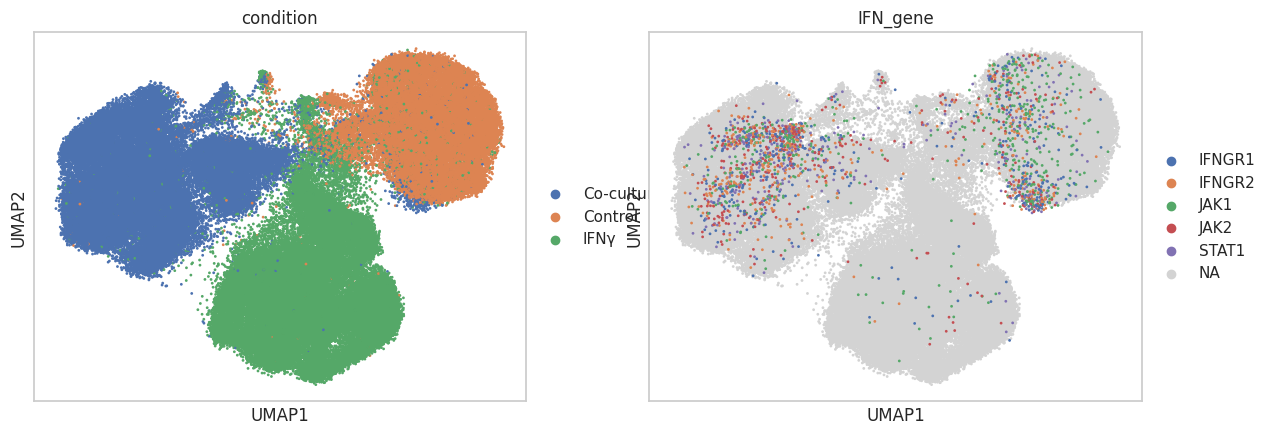

In [121]:
muvi.pl.umap(model, color=["condition", "IFN_gene"], s=16)

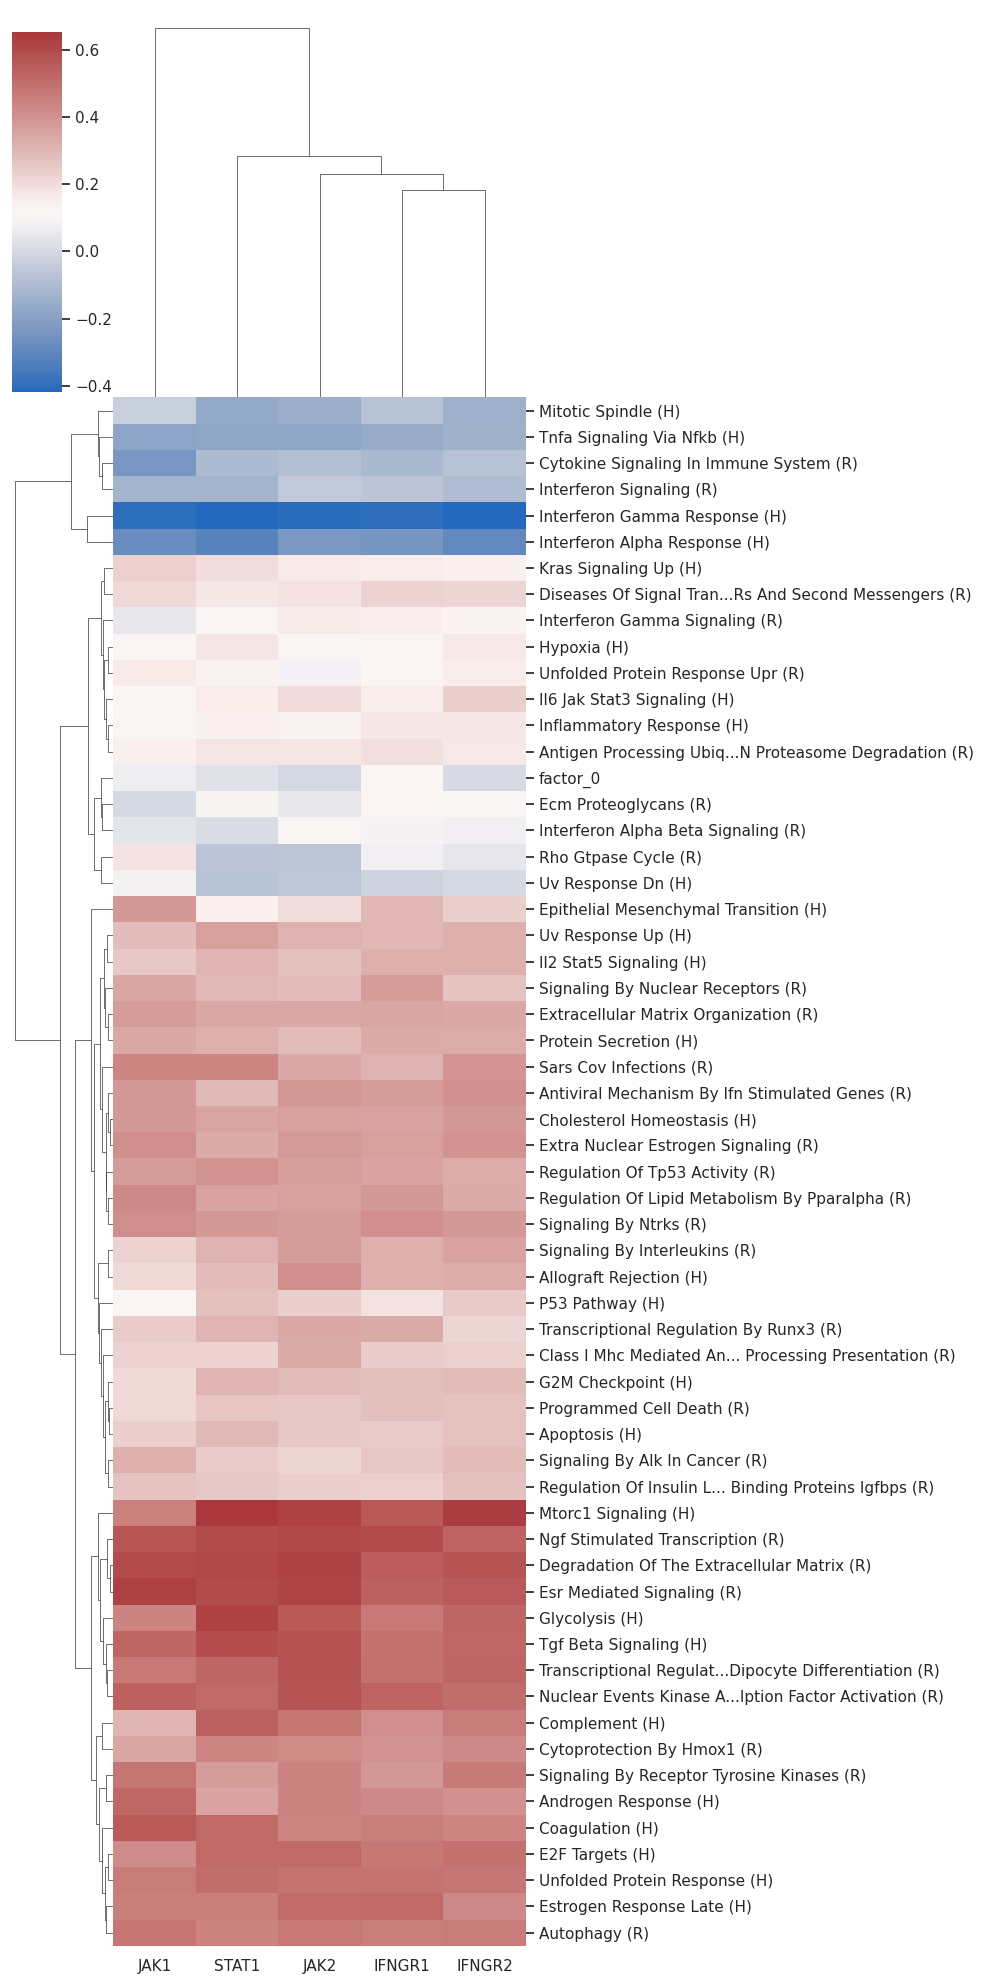

In [98]:
sns.clustermap(condition_w.loc[model._cache.factor_adata.obsm["filtered_scores"].columns[model.n_dense_factors:], ifn_genes], figsize=(10, 20), yticklabels=True, cmap=sns.color_palette("vlag", as_cmap=True))

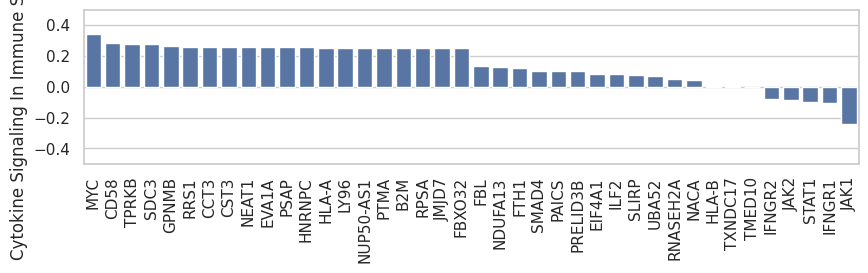

In [38]:
plt.figure(figsize=(10, 2))
fac_name = top_cond_factors[0]
pos_weights = condition_w.loc[fac_name, :].sort_values(ascending=False).iloc[:20]
neg_weights = condition_w.loc[fac_name, :].sort_values(ascending=False).iloc[-20:]
top_weights_vector = pd.concat([pos_weights, neg_weights])
top_weights_vector.index = top_weights_vector.index.astype(str)
ax = sns.barplot(top_weights_vector)
ax.set(ylim=(-0.5, 0.5))
plt.xticks(rotation=90)
plt.show()

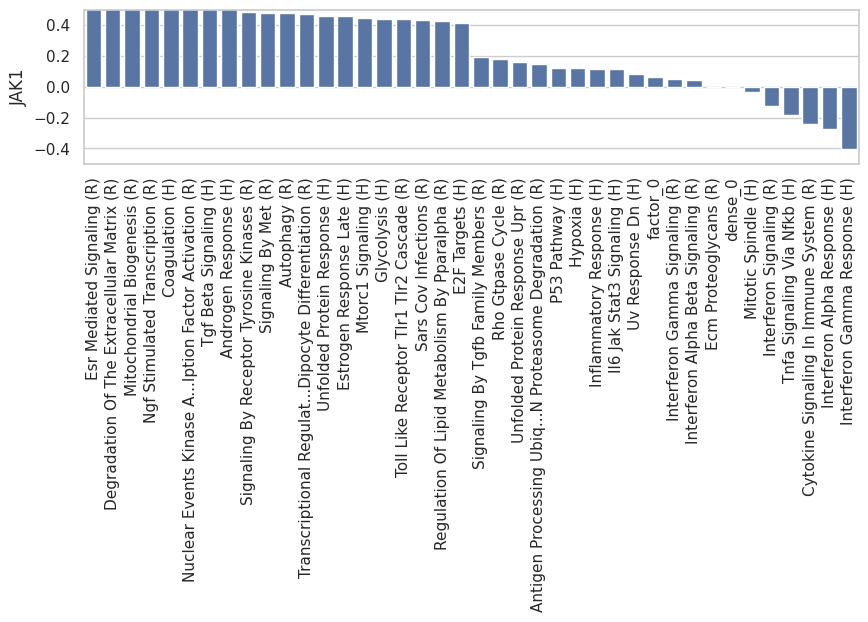

In [41]:
plt.figure(figsize=(10, 2))
cond_name = "JAK1"
pos_weights = condition_w[cond_name].sort_values(ascending=False).iloc[:20]
neg_weights = condition_w[cond_name].sort_values(ascending=False).iloc[-20:]
ax = sns.barplot(pd.concat([pos_weights, neg_weights]))
ax.set(ylim=(-0.5, 0.5))
plt.xticks(rotation=90)
plt.show()

In [150]:
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

In [124]:
condition_w_scale = pd.DataFrame(pyro.get_param_store().get_param("MuVI._guide.scales.w_condition").cpu().detach().numpy()[:, model.factor_order].T, index=model.factor_names, columns=cond_cov.columns)
condition_w_scale.head()

A2M     ACSL3     ACTA2  \
dense_0                                  1.000000  1.000000  1.000000   
Interferon Gamma Response (H)            0.026152  0.039602  0.025382   
Cytokine Signaling In Immune System (R)  0.027006  0.040724  0.025393   
E2F Targets (H)                          0.027153  0.039660  0.025781   
G2M Checkpoint (H)                       0.027946  0.040467  0.025621   

                                            AEBP1       AGA      AHCY  \
dense_0                                  1.000000  1.000000  1.000000   
Interferon Gamma Response (H)            0.027219  0.028225  0.112063   
Cytokine Signaling In Immune System (R)  0.026930  0.028108  0.115056   
E2F Targets (H)                          0.025609  0.027984  0.116161   
G2M Checkpoint (H)                       0.026724  0.028513  0.113845   

                                            AHNAK     APOC2      APOD  \
dense_0                                  1.000000  1.000000  1.000000   
Interferon Gamma Response (H)            0.030100  0.028278  0.028427   
Cytokine Signaling In Immune System (R)  0.029499  0.028836  0.029302   
E2F Targets (H)                          0.029865  0.029133  0.029584   
G2M Checkpoint (H)                       0.029613  0.027434  0.029014   

                                             APOE  ...     UBA52       UBC  \
dense_0                                  1.000000  ...  1.000000  1.000000   
Interferon Gamma Response (H)            0.027762  ...  0.120933  0.046058   
Cytokine Signaling In Immune System (R)  0.028717  ...  0.115217  0.045954   
E2F Targets (H)                          0.027557  ...  0.116466  0.046798   
G2M Checkpoint (H)                       0.028772  ...  0.117952  0.044252   

                                             UCN2   UQCRFS1     UQCRH  \
dense_0                                  1.000000  1.000000  1.000000   
Interferon Gamma Response (H)            0.032411  0.038905  0.048161   
Cytokine Signaling In Immune System (R)  0.031804  0.041561  0.048187   
E2F Targets (H)                          0.032064  0.039607  0.047534   
G2M Checkpoint (H)                       0.032421  0.039084  0.047456   

                                             VAT1    VDAC2      WBP2  \
dense_0                                  1.000000  1.00000  1.000000   
Interferon Gamma Response (H)            0.034062  0.02805  0.027301   
Cytokine Signaling In Immune System (R)  0.033458  0.02777  0.027081   
E2F Targets (H)                          0.033089  0.02783  0.027025   
G2M Checkpoint (H)                       0.033575  0.02793  0.028127   

                                            WNT7A    XAGE1A  
dense_0                                  1.000000  1.000000  
Interferon Gamma Response (H)            0.028743  0.033373  
Cytokine Signaling In Immune System (R)  0.027671  0.032289  
E2F Targets (H)                          0.028303  0.035393  
G2M Checkpoint (H)                       0.027369  0.033878  

[5 rows x 242 columns]

In [126]:
cond_cov.shape

(121223, 242)

In [131]:
# Compute predictions for all targets
Z_pred = cond_cov @ condition_w.T  # (n x p) @ (p x m) = (n x m)
Z_pred.shape

(121223, 79)

In [133]:
# Compute residuals
E = model.get_factor_scores() - Z_pred  # (n x m)
E.shape

(121223, 79)

In [135]:
# Compute Residual Covariance Matrix (for multiple outputs)
sigma_squared = (E.T @ E) / (model.n_samples - model.n_features["rna"])  # (m x m) covariance matrix
sigma_squared.shape

(79, 79)

In [153]:
# Compute t-statistics
t_stats = condition_w / condition_w_scale  # (p x m)
t_stats.shape

(79, 242)

In [154]:
# Compute p-values using the t-distribution
p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df=model.n_samples - model.n_features["rna"]))
p_values = pd.DataFrame(p_values, index=t_stats.index, columns=t_stats.columns)
p_values.shape

(79, 242)

<Axes: >

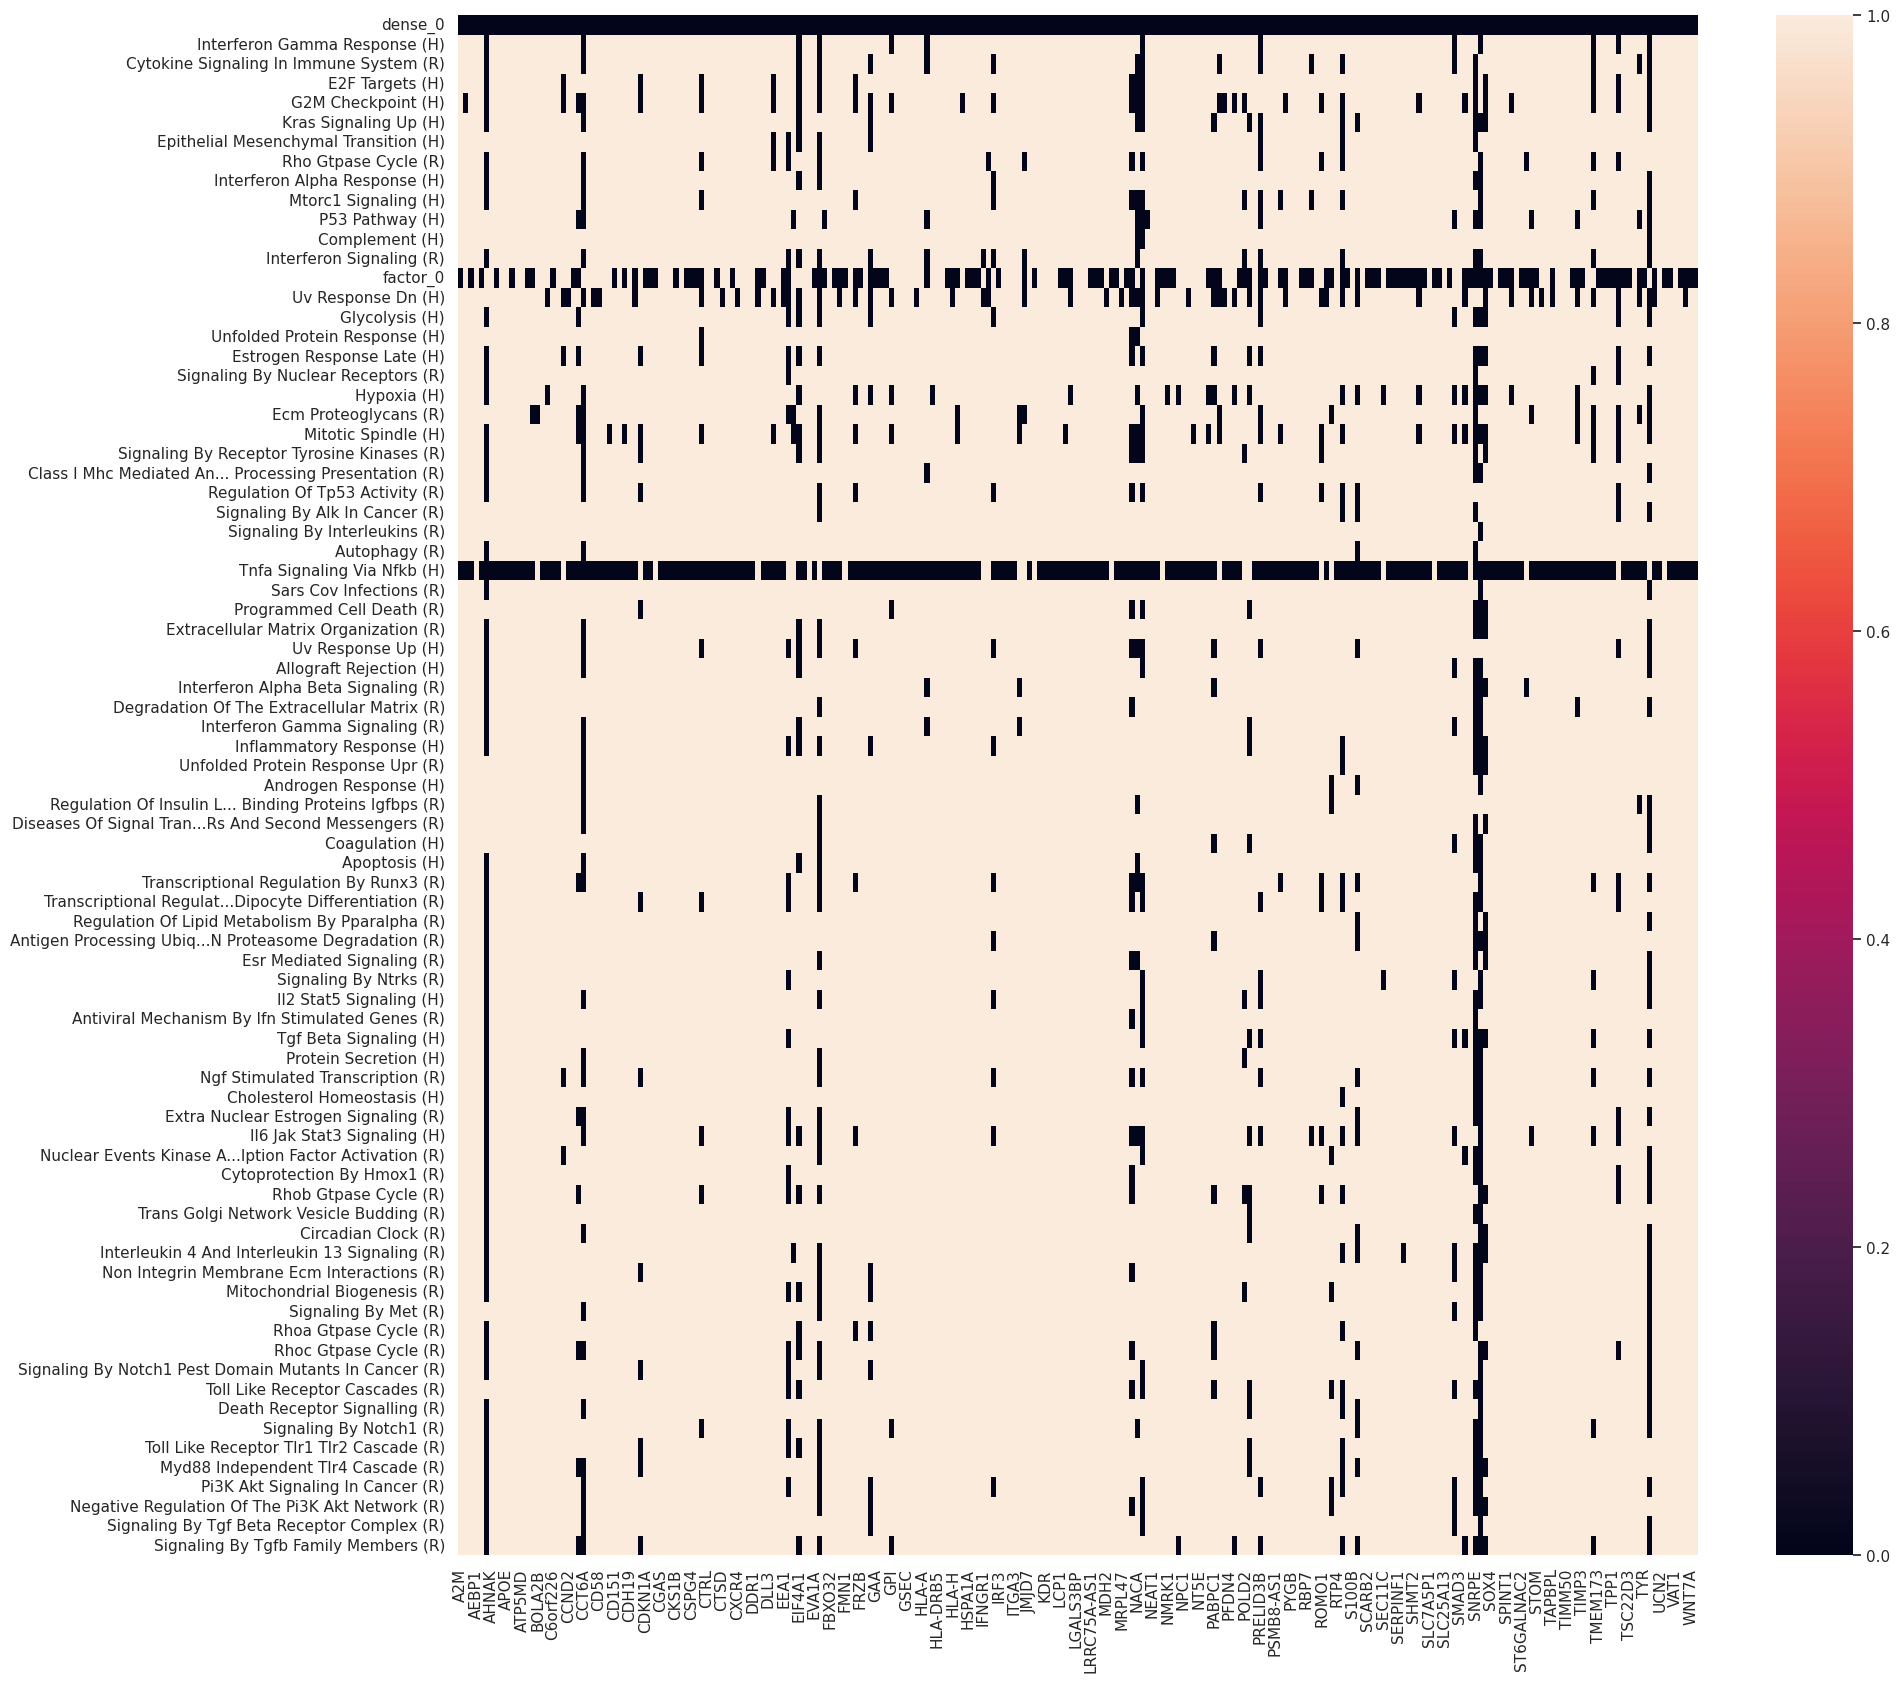

In [160]:
plt.figure(figsize=(20, 20))
sns.heatmap(p_values < 0.05)

<Axes: >

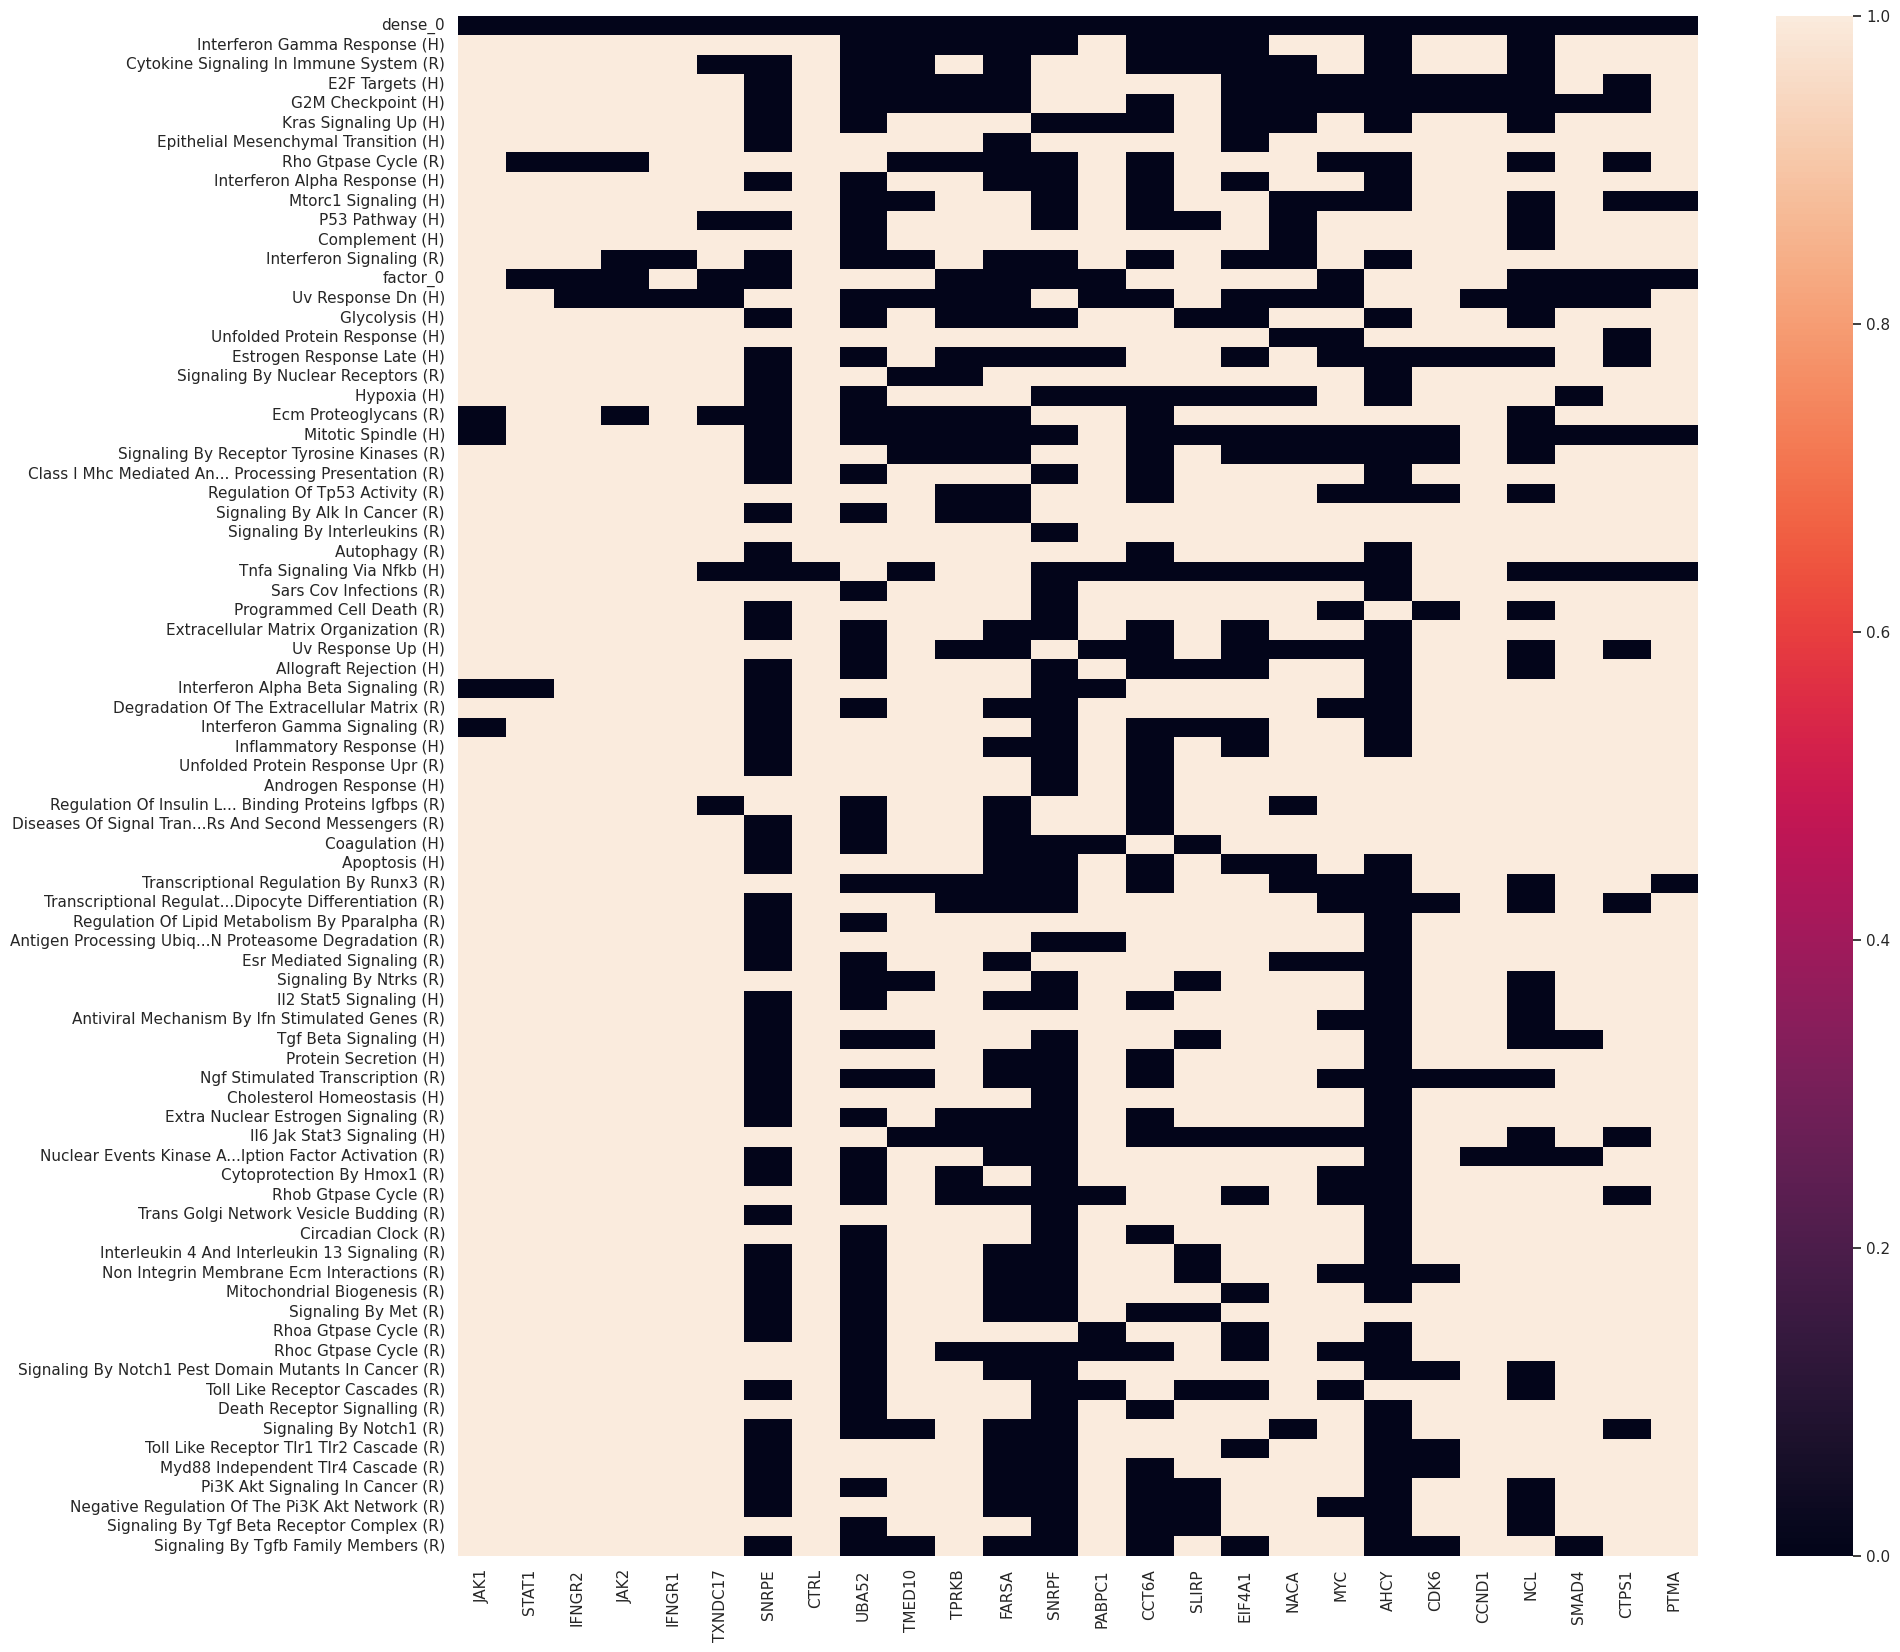

In [162]:
plt.figure(figsize=(20, 20))
sns.heatmap(p_values.loc[:, relevant_conditions] < 0.05)

<Axes: >

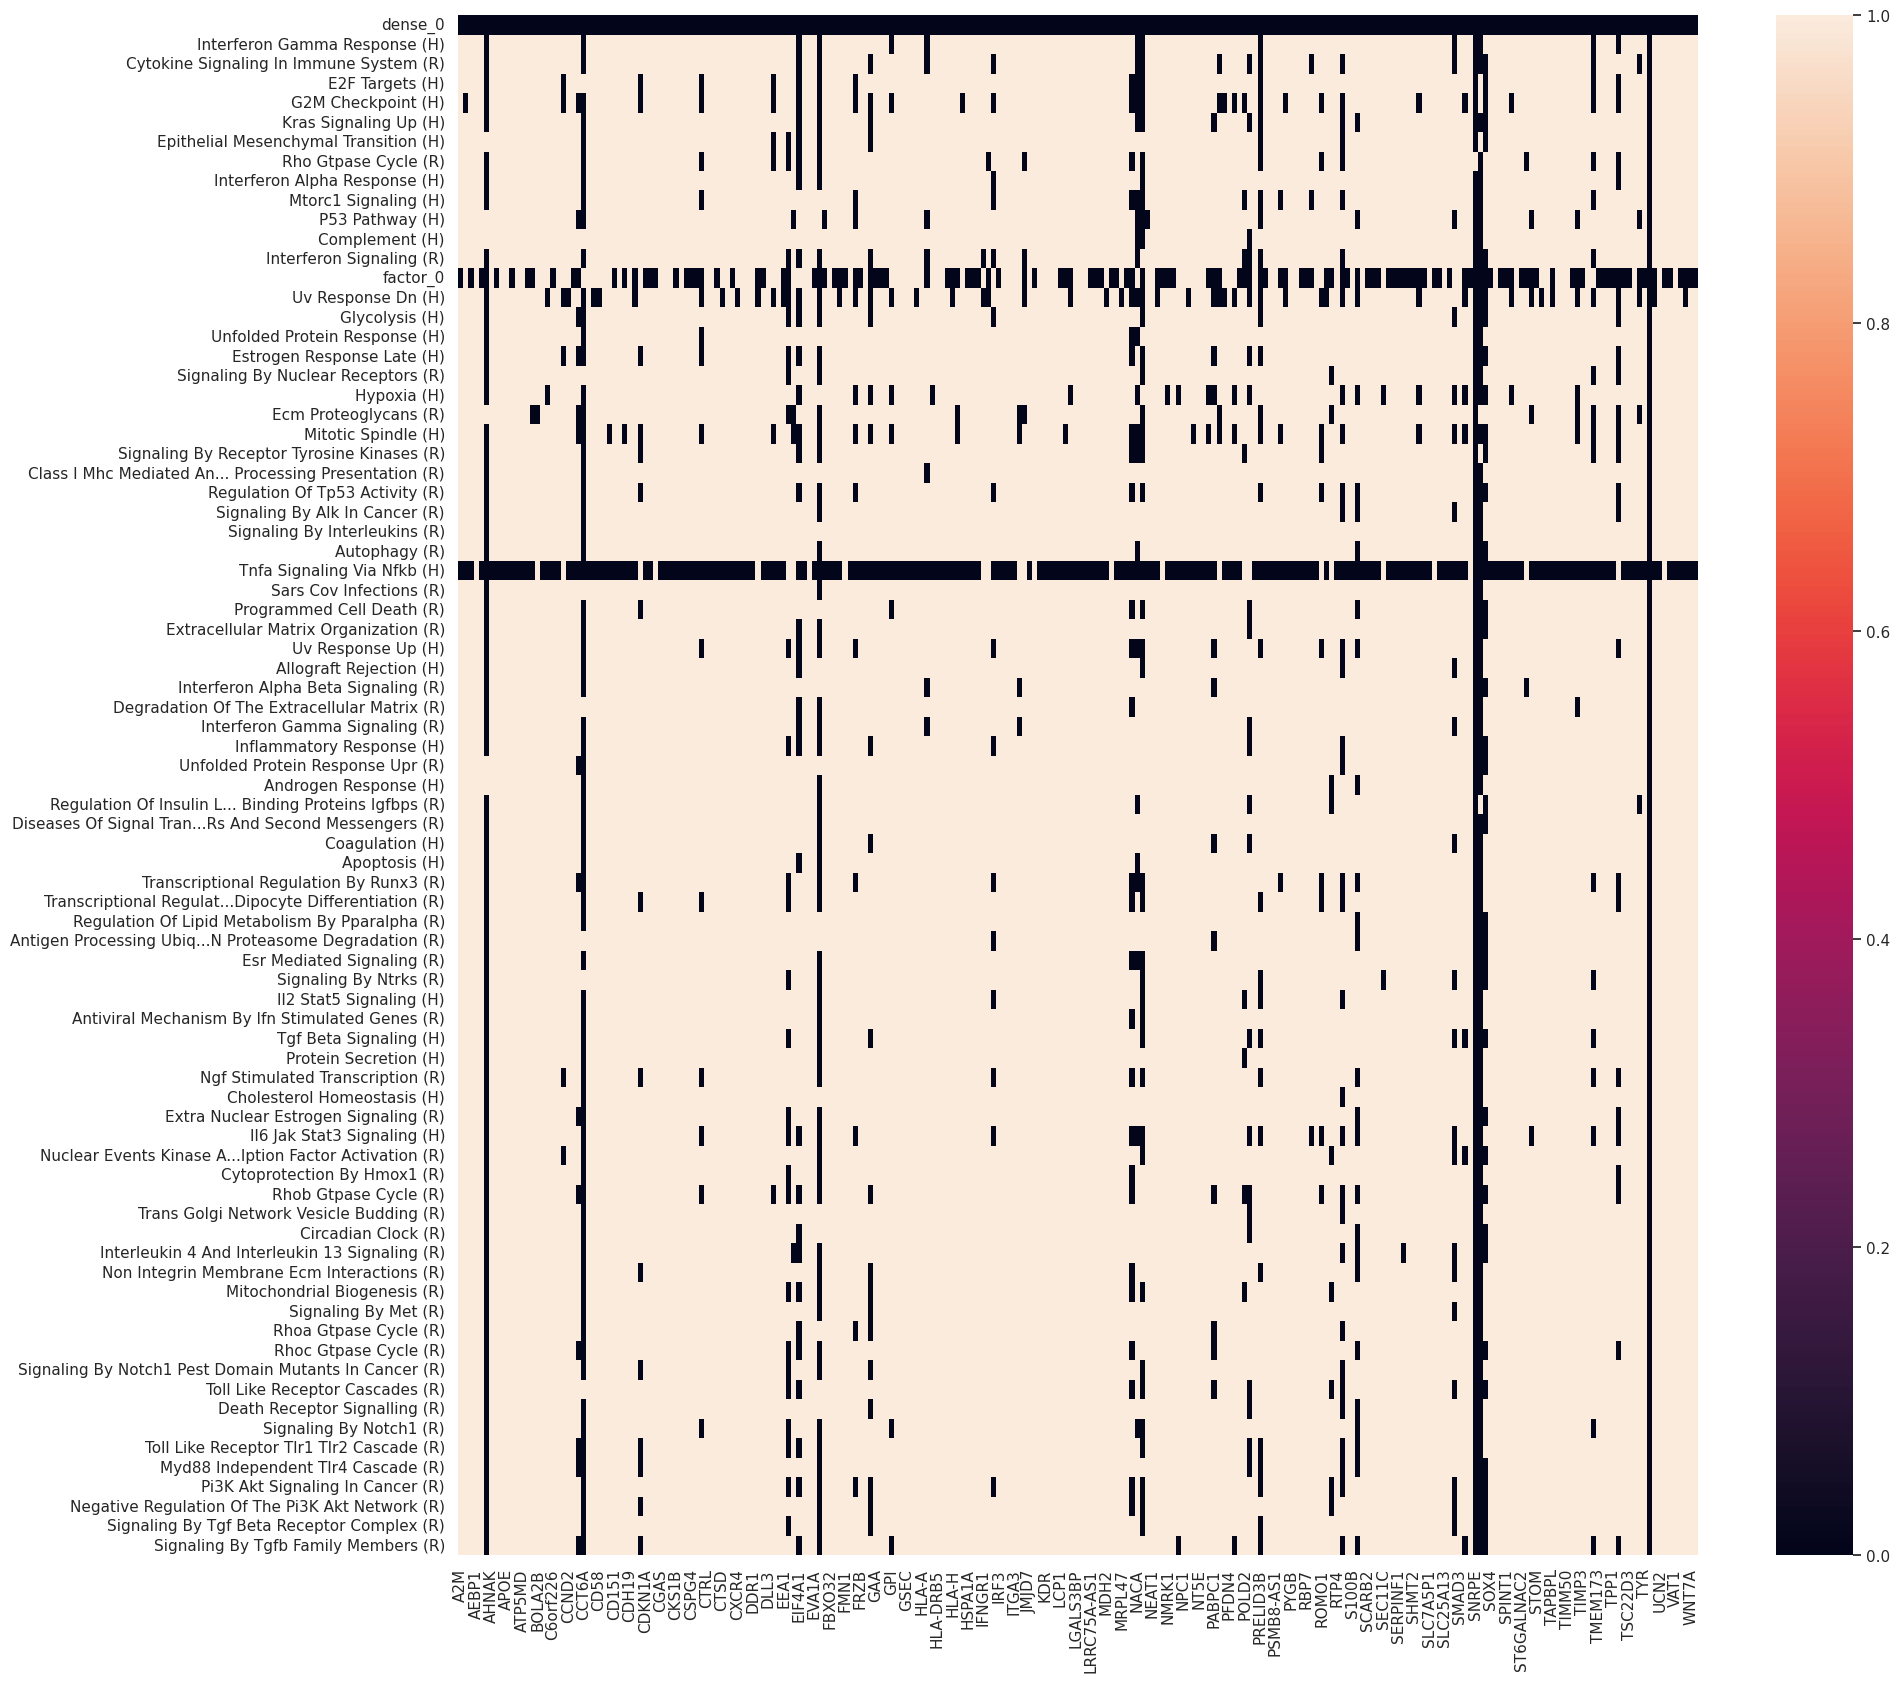

In [159]:
# p_values.apply(lambda row: multipletests(row, method="bonferroni")[1], axis=0)
plt.figure(figsize=(20, 20))
sns.heatmap(p_values.apply(lambda row: multipletests(row, method="fdr_bh")[1], axis=0) < 0.05)

<Axes: >

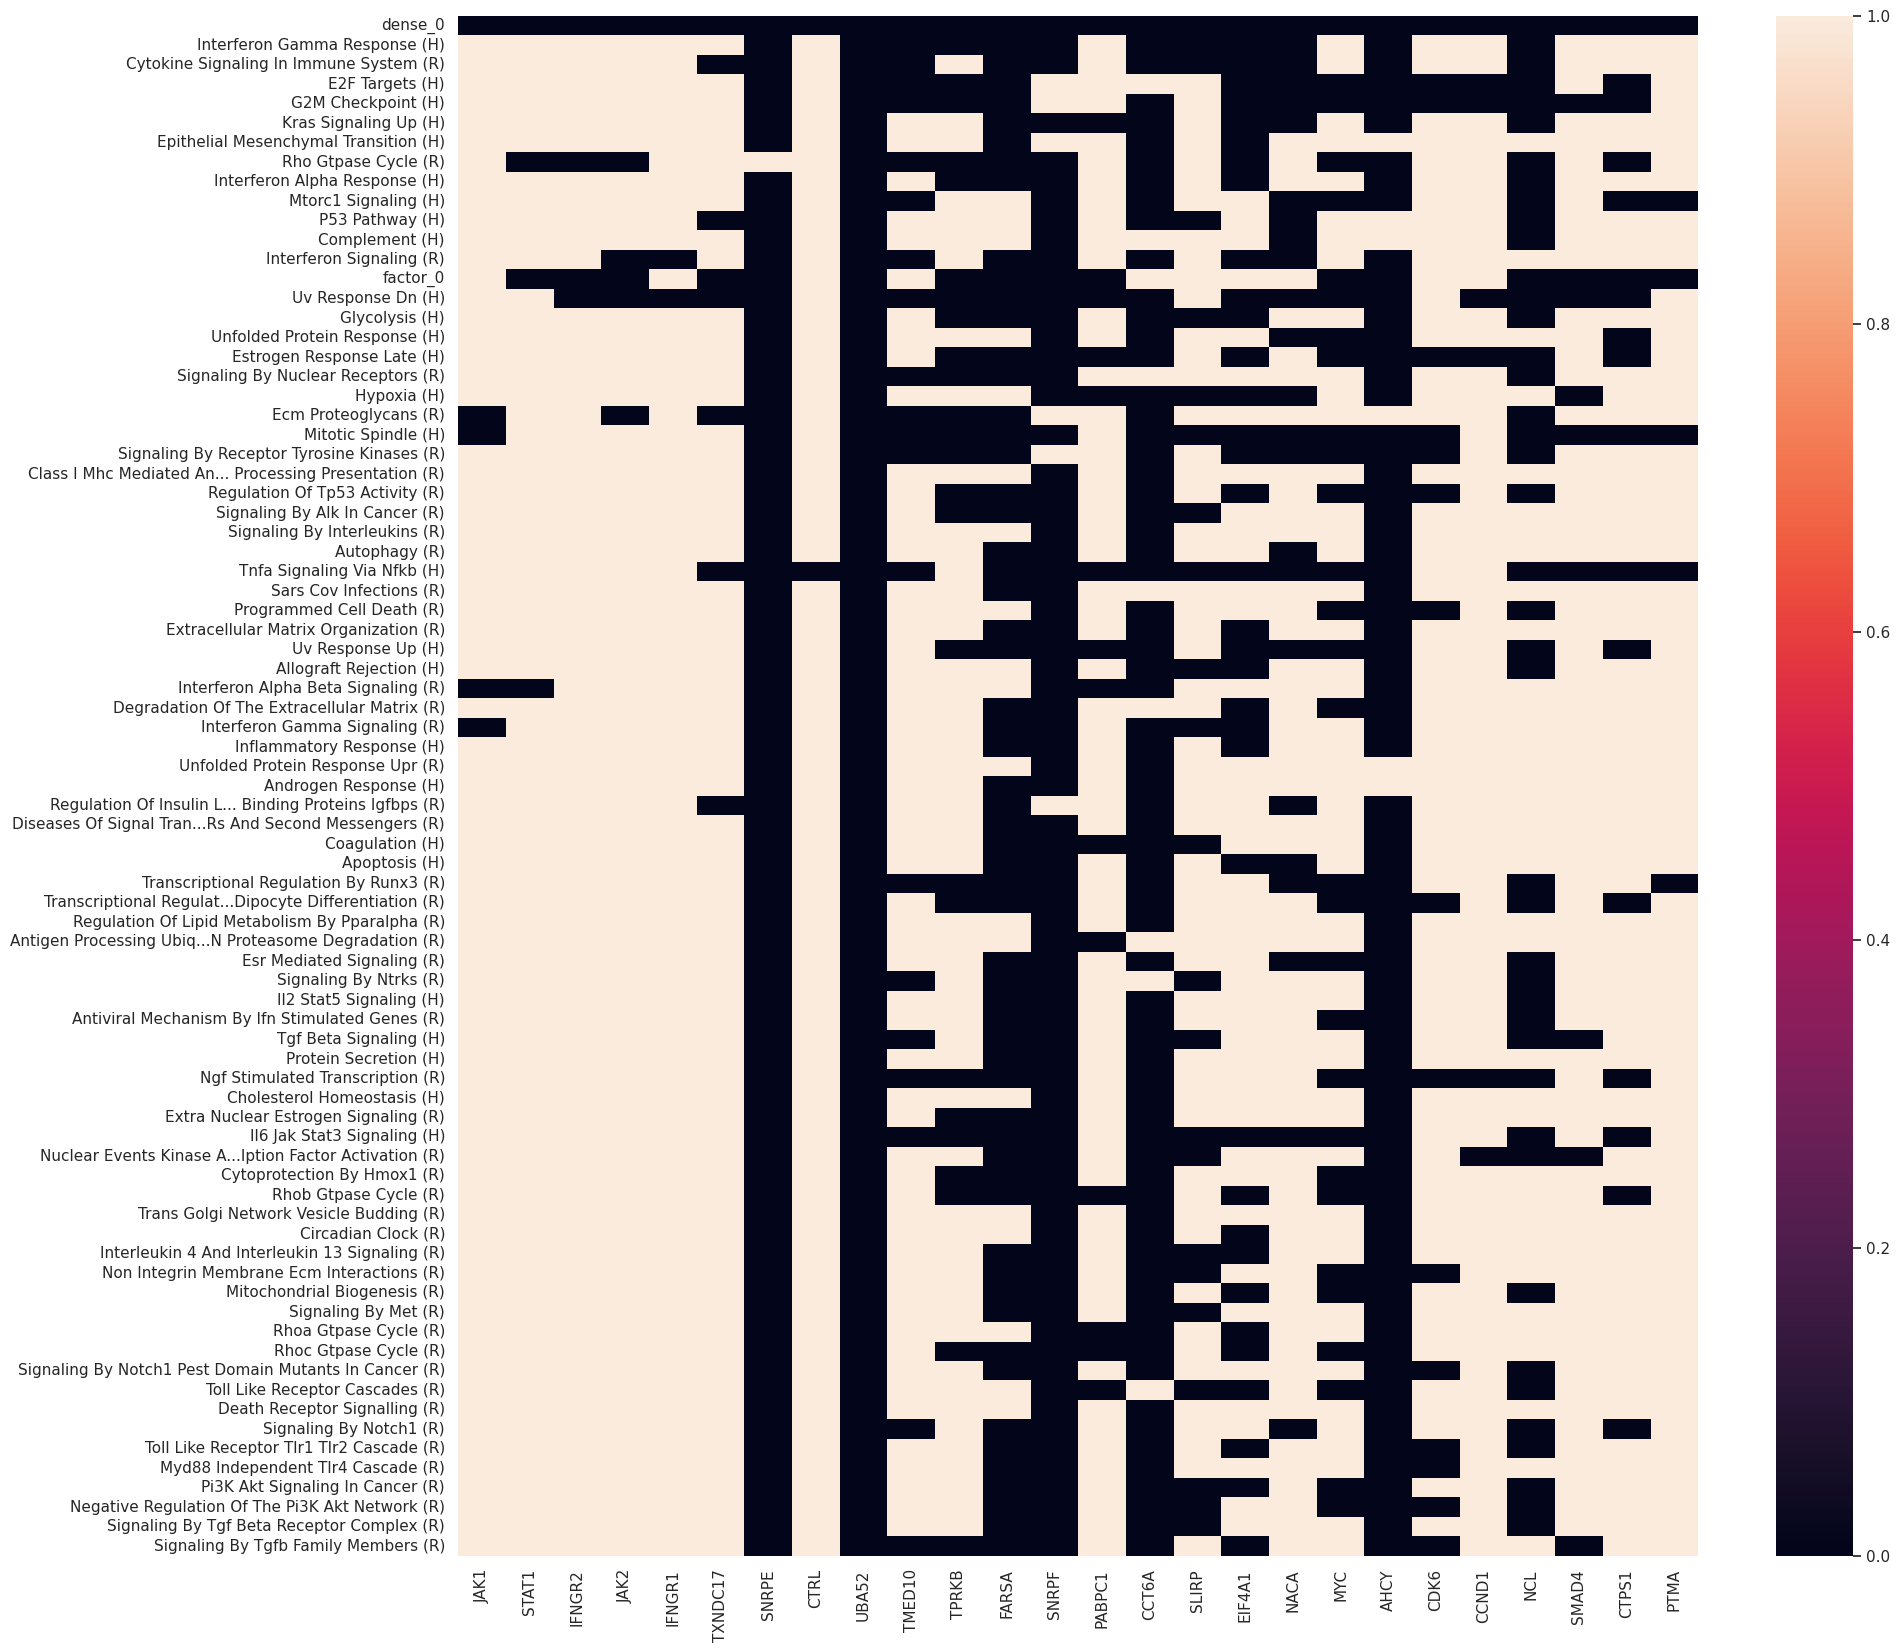

In [163]:
# p_values.apply(lambda row: multipletests(row, method="bonferroni")[1], axis=0)
plt.figure(figsize=(20, 20))
sns.heatmap(p_values.apply(lambda row: multipletests(row, method="fdr_bh")[1], axis=0).loc[:, relevant_conditions] < 0.05)